# fNIRS Data Processing Pipeline

This notebook provides two comprehensive workflows for processing functional Near-Infrared Spectroscopy (fNIRS) data:

## Section 1: Raw fNIRS Preprocessing with MNE-Python
Process raw infrared light intensity data (`.snirf` format) into hemoglobin concentration data:
- Optical density conversion and motion artifact correction (TDDR)
- Beer-Lambert law transformation to HbO/HbR concentrations
- Quality control with Scalp Coupling Index (SCI)
- Bandpass filtering (0.001-0.1 Hz) to preserve hemodynamic responses
- Visualization and validation

## Section 2: MATLAB Homer3 Import Pipeline
Import preprocessed concentration data from MATLAB Homer3 and prepare for algorithm development:
- Load preprocessed HbO/HbR/HbT CSV files
- Create MNE-compatible data structures with custom montage
- Task-specific epoching (GNG, VF, 1backWM, SS)
- Baseline correction and optional z-score normalization
- Export to `.npy` format for GNN/ML development

**Data Location:** `../data/healthy/` and `../data/anxiety/`  
**Tasks Available:** 1backWM (working memory), VF (verbal fluency), GNG (go/no-go), SS (Stroop)

## Imports and Setup

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from copy import deepcopy
from itertools import compress

# MNE-Python for fNIRS processing
import mne
from mne.preprocessing.nirs import optical_density, beer_lambert_law, scalp_coupling_index
from mne.viz import plot_compare_evokeds

# MNE-NIRS extensions
import mne_nirs
from mne_nirs.channels import get_long_channels, get_short_channels
from mne_nirs.signal_enhancement import enhance_negative_correlation, short_channel_regression
from mne_nirs.visualisation import plot_nirs_source_detector, plot_glm_surface_projection

# Add processor module to path
from processor import FNIRSDataProcessor, FNIRSDataset, validate_data_type

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ All libraries imported successfully")
print(f"MNE version: {mne.__version__}")
print(f"MNE-NIRS version: {mne_nirs.__version__}")

In [ ]:
# Define paths
data_dir = Path('../data')
healthy_dir = data_dir / 'healthy'
anxiety_dir = data_dir / 'anxiety'
montage_file = Path('../data/brainproducts-RNP-BA-128-custom.elc')

# Verify paths exist
assert data_dir.exists(), f"Data directory not found: {data_dir}"
assert healthy_dir.exists(), f"Healthy subjects directory not found: {healthy_dir}"
assert anxiety_dir.exists(), f"Anxiety subjects directory not found: {anxiety_dir}"
assert montage_file.exists(), f"Montage file not found: {montage_file}"

print(f"Data directory: {data_dir.resolve()}")
print(f"Healthy subjects: {len(list(healthy_dir.glob('AH*')))} folders")
print(f"Anxiety subjects: {len(list(anxiety_dir.glob('*A*')))} folders")
print(f"Montage file: {montage_file.resolve()}")

---
## Section 1: Raw fNIRS Preprocessing with MNE-Python

This section demonstrates the complete preprocessing pipeline for raw fNIRS data:
1. Load raw `.snirf` files containing light intensity measurements
2. Convert to optical density and apply motion artifact correction
3. Transform to hemoglobin concentration using Beer-Lambert law
4. Detect and interpolate bad channels using Scalp Coupling Index (SCI)
5. Apply bandpass filtering to remove physiological noise
6. Visualize and validate the preprocessed data

**Signal Physiology Reference:**
- **0.01-0.1 Hz**: Hemodynamic response (neural activity) - **PRESERVE**
- **< 0.01 Hz**: Slow drifts/baseline shifts - **REMOVE**
- **0.1-0.15 Hz**: Mayer waves (blood pressure oscillations) - **REMOVE**
- **~0.25 Hz**: Respiratory artifacts - **REMOVE**
- **~1 Hz**: Cardiac artifacts - **REMOVE**

### 1.1 Raw to Hemoglobin Concentration Data

This subsection covers the complete preprocessing pipeline from raw light intensity to hemoglobin concentration:
- Load raw `.snirf` files and set custom montage
- Convert to optical density with TDDR motion correction
- Apply Beer-Lambert law to obtain HbO/HbR concentrations
- Detect and interpolate bad channels using Scalp Coupling Index
- Apply bandpass filtering (0.001-0.1 Hz)
- Compute total hemoglobin (HbT)

In [ ]:
# ============================================================================
# SECTION 1.1: RAW TO HEMOGLOBIN CONCENTRATION DATA
# ============================================================================

# ----------------------------------------------------------------------------
# 1. Load Raw fNIRS Data
# ----------------------------------------------------------------------------
# Select a subject and task for demonstration
subject_id = 'AH014'  # Change to any available subject
task = 'GNG'          # Options: '1backWM', 'VF', 'GNG', 'SS'
group = 'healthy'     # 'healthy' or 'anxiety'

# Find and load the .snirf file
subject_dir = data_dir / group / subject_id / task
snirf_files = list(subject_dir.glob('*.snirf'))

if not snirf_files:
    print(f"No .snirf files found in {subject_dir}")
    print("Available files:", list(subject_dir.glob('*')))
else:
    snirf_file = snirf_files[0]
    print(f"Loading: {snirf_file.name}")

    # Load raw fNIRS data
    intensity = mne.io.read_raw_nirx(str(subject_dir), verbose=True)

    print(f"\nData info:")
    print(f"  Duration: {intensity.times[-1]:.1f} seconds")
    print(f"  Sampling frequency: {intensity.info['sfreq']} Hz")
    print(f"  Number of channels: {len(intensity.ch_names)}")

# ----------------------------------------------------------------------------
# 2. Set Custom Montage and View Annotations
# ----------------------------------------------------------------------------
# Set custom montage for electrode positions
montage = mne.channels.read_custom_montage(str(montage_file), head_size=0.0825)
intensity.set_montage(montage)

print("\nAnnotations in raw data:")
print(intensity.annotations)

# Rename annotations for clarity
annotation_mapping = {
    '2.0': 'Practice',
    '1.0': 'Baseline',
    '3.0': 'Task'
}

for old_desc, new_desc in annotation_mapping.items():
    intensity.annotations.rename({old_desc: new_desc})

# Remove practice trials if present
practice_idx = [i for i, desc in enumerate(intensity.annotations.description)
                if desc == 'Practice']
if practice_idx:
    intensity.annotations.delete(practice_idx)
    print(f"\nRemoved {len(practice_idx)} practice trial(s)")

print("\nUpdated annotations:")
print(intensity.annotations)

# ----------------------------------------------------------------------------
# 3. Convert to Optical Density and Apply Motion Artifact Correction
# ----------------------------------------------------------------------------
# Convert raw intensity to optical density
od = optical_density(intensity)
print("\n✓ Converted to optical density")

# Apply TDDR (Temporal Derivative Distribution Repair) for motion artifact correction
od_corrected = mne.preprocessing.nirs.temporal_derivative_distribution_repair(od)
print("✓ Applied motion artifact correction (TDDR)")

# ----------------------------------------------------------------------------
# 4. Quality Control: Scalp Coupling Index (SCI)
# ----------------------------------------------------------------------------
# Calculate Scalp Coupling Index to identify bad channels
# NOTE: SCI must be computed on optical density data, not hemoglobin concentration
sci = mne.preprocessing.nirs.scalp_coupling_index(od_corrected)

# Set threshold for bad channels (typically 0.5 or 0.6)
sci_threshold = 0.5
bad_channels = list(compress(od_corrected.ch_names, sci < sci_threshold))

print(f"\nScalp Coupling Index Analysis:")
print(f"  Threshold: {sci_threshold}")
print(f"  Bad channels detected: {len(bad_channels)}")
if bad_channels:
    print(f"  Bad channel names: {bad_channels[:10]}" +
          (f" ... and {len(bad_channels)-10} more" if len(bad_channels) > 10 else ""))

# Mark and interpolate bad channels in optical density data
od_corrected.info['bads'] = bad_channels

if len(bad_channels) > 0:
    od_corrected.interpolate_bads()
    print(f"✓ Interpolated {len(bad_channels)} bad channel(s)")
else:
    print("✓ No bad channels to interpolate")

print(f"\nSCI statistics:")
print(f"  Mean: {np.mean(sci):.3f}")
print(f"  Median: {np.median(sci):.3f}")
print(f"  Min: {np.min(sci):.3f}")
print(f"  Max: {np.max(sci):.3f}")

# ----------------------------------------------------------------------------
# 5. Apply Beer-Lambert Law to Convert to Hemoglobin Concentration
# ----------------------------------------------------------------------------
# Convert optical density to hemoglobin concentration (HbO and HbR)
haemo = beer_lambert_law(od_corrected, ppf=6.0)

print("\n✓ Applied Beer-Lambert law conversion")
print(f"  Channels: {len(haemo.ch_names)}")

# Display first few channel names
print("\nFirst 10 channels:")
for i, ch_name in enumerate(haemo.ch_names[:10]):
    print(f"  {i+1}. {ch_name}")

# Filter for long channels only (> 30mm source-detector separation)
haemo = get_long_channels(haemo)

# Separate HbO and HbR channels
picks_hbo = mne.pick_types(haemo.info, fnirs='hbo')
picks_hbr = mne.pick_types(haemo.info, fnirs='hbr')

print(f"\n✓ Filtered to long channels")
print(f"  HbO channels: {len(picks_hbo)}")
print(f"  HbR channels: {len(picks_hbr)}")

# ----------------------------------------------------------------------------
# 6. Apply Bandpass Filtering
# ----------------------------------------------------------------------------
# Apply IIR Butterworth bandpass filter to preserve hemodynamic responses
# while removing slow drifts, Mayer waves, respiratory and cardiac artifacts
haemo_filtered = haemo.copy()
haemo_filtered.filter(
    l_freq=0.001,          # High-pass: preserve low frequencies down to 0.001 Hz
    h_freq=0.1,            # Low-pass: remove cardiac, respiratory, Mayer waves
    method='iir',
    iir_params={'order': 4, 'ftype': 'butter'},
    phase='zero-double',
    verbose=True
)

print("\n✓ Applied bandpass filter (0.001-0.1 Hz)")

# ----------------------------------------------------------------------------
# 7. Compute Total Hemoglobin (HbT = HbO + HbR)
# ----------------------------------------------------------------------------
# Calculate HbT by adding HbO and HbR
hbo_data, _ = haemo_filtered[picks_hbo, :]
hbr_data, _ = haemo_filtered[picks_hbr, :]
hbt_data = hbo_data + hbr_data

# Create HbT channel names by iterating through all channel names
# This avoids the TypeError from indexing a list with a numpy array
hbt_channel_names = [ch_name.replace('hbo', 'hbt') for ch_name in haemo_filtered.ch_names if 'hbo' in ch_name]

# Create HbT channel info
hbt_info = mne.create_info(
    ch_names=hbt_channel_names,
    sfreq=haemo_filtered.info['sfreq'],
    ch_types=['fnirs_cw_amplitude'] * len(hbt_channel_names)
)

# Create HbT Raw object
hbt = mne.io.RawArray(hbt_data, hbt_info, first_samp=haemo_filtered.first_samp)

# Combine HbO, HbR, and HbT
haemo_combined = haemo_filtered.add_channels([hbt], force_update_info=True)

print(f"\n✓ Computed HbT channels")
print(f"  Total channels: {len(haemo_combined.ch_names)}")
print(f"  HbO: {len(picks_hbo)}, HbR: {len(picks_hbr)}, HbT: {len(hbt_channel_names)}")

print("\n" + "="*80)
print("SECTION 1.1 COMPLETE: Raw data successfully converted to hemoglobin concentration")
print("="*80)

### 1.2 Visualization

Visualize the preprocessing results including power spectral density and evoked responses.

In [ ]:
# Compare PSD before and after filtering
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Before filtering
haemo.compute_psd(fmax=2).plot(
    picks='hbo',
    exclude='bads',
    average=True,
    amplitude=False,
    axes=ax[0],
    show=False
)
ax[0].set_title('Before Filtering (HbO)', fontsize=12, fontweight='bold')
ax[0].axvline(0.1, color='red', linestyle='--', alpha=0.7, label='0.1 Hz cutoff')
ax[0].axvline(0.25, color='orange', linestyle='--', alpha=0.7, label='Respiration (~0.25 Hz)')
ax[0].axvline(1.0, color='purple', linestyle='--', alpha=0.7, label='Cardiac (~1 Hz)')
ax[0].legend()

# After filtering
haemo_filtered.compute_psd(fmax=2).plot(
    picks='hbo',
    exclude='bads',
    average=True,
    amplitude=False,
    axes=ax[1],
    show=False
)
ax[1].set_title('After Filtering (HbO)', fontsize=12, fontweight='bold')
ax[1].axvline(0.1, color='red', linestyle='--', alpha=0.7, label='0.1 Hz cutoff')

plt.tight_layout()
plt.show()

In [ ]:
# Create epochs for visualization
# Task-specific epoch durations
epoch_params = {
    '1backWM': (0, 90),
    'VF': (0, 60),
    'GNG': (0, 35),
    'SS': (0, 60)
}

tmin, tmax = epoch_params.get(task, (0, 35))

# Create epochs around task events
events, event_dict = mne.events_from_annotations(haemo_combined)
epochs = mne.Epochs(
    haemo_combined,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    reject_by_annotation=True,
    preload=True,
    verbose=True
)

print(f"\nEpochs created:")
print(f"  Number of epochs: {len(epochs)}")
print(f"  Time range: {tmin} to {tmax} seconds")
print(f"  Event types: {list(event_dict.keys())}")

In [ ]:
# Plot evoked responses for HbO, HbR, and HbT
if 'Task' in event_dict:
    evoked_hbo = epochs['Task'].average(picks='hbo')
    evoked_hbr = epochs['Task'].average(picks='hbr')

    # HbT requires special handling: pick channels by name pattern instead of type
    # because HbT channels have 'fnirs_cw_amplitude' type, not 'hbt' type
    picks_hbt = [ch_name for ch_name in epochs.info['ch_names'] if 'hbt' in ch_name]
    evoked_hbt = epochs['Task'].average(picks=picks_hbt)

    # Rename channels to remove type suffixes (' hbo', ' hbr', ' hbt')
    # This ensures all evoked objects have identical channel names,
    # which is required by plot_compare_evokeds
    evoked_hbo.rename_channels(lambda x: x[:-4] if ' ' in x else x)
    evoked_hbr.rename_channels(lambda x: x[:-4] if ' ' in x else x)
    evoked_hbt.rename_channels(lambda x: x[:-4] if ' ' in x else x)

    # Create comparison plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot all three hemoglobin types for comparison
    plot_compare_evokeds(
        {'HbO': evoked_hbo, 'HbR': evoked_hbr, 'HbT': evoked_hbt},
        combine='mean',
        ci=0.95,
        axes=ax,
        show=False
    )

    ax.set_title(f'Average Evoked Response - {subject_id} ({task})',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Concentration Change (μM·mm)', fontsize=12)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No 'Task' events found for evoked response visualization")

### 1.3. Batch Preprocessing of RAW fNIRS Data with `MNE-Python`

In [14]:
# Standard library imports
import copy
from pathlib import Path
import shutil
from itertools import compress
import logging

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# MNE-related imports
import mne
from mne import create_info
from mne.io import RawArray
from mne_nirs.signal_enhancement import enhance_negative_correlation

# User configuration
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*MNE has not been tested with Aurora version.*")

class FNIRSDataProcessorMNE:
    """
    Process fNIRS data from MATLAB HOMER3 preprocessed output.

    Parameters:
    - data_dir: Path to directory containing 'healthy' and 'anxiety' folders with raw data
    - output_dir: Path to save processed data and plots
    - **kwargs: Additional parameters including:
        - data_type: 'hbo', 'hbr', 'hbt', or 'all' (default: 'hbo')
        - task_type: 'GNG', 'VF', 'SS', or '1backWM' (default: 'GNG')
        - interpolate_bad_channels: bool, whether to interpolate bad channels (default: False)
        - negative_correlation: bool, whether to apply negative correlation enhancement (default: False)
        - apply_baseline_correction: bool, whether to apply baseline correction (default: False)
        - apply_zscore: bool, whether to apply z-score normalization (default: False)
        - apply_motion_correction: bool, whether to apply TDDR motion artifact correction (default: False)
        - sci_threshold: float, scalp coupling index threshold for bad channels (default: 0.5)
        - save_data_format: 'csv' or 'npy' (default: 'csv')
    """
    def __init__(
            self,
            data_dir,
            output_dir,
            **kwargs
    ):
        data_dir = Path(data_dir)
        self.healthy_dir = data_dir / 'healthy'
        self.anxiety_dir = data_dir / 'anxiety'
        self.output_dir = Path(output_dir)

        # Explicitly retrieve parameters with kwargs.get
        self.data_type = kwargs.get('data_type', 'hbo')  # Choose 'hbo', 'hbr', 'hbt', or 'all'
        self.task_type = kwargs.get('task_type', 'GNG')  # Choose GNG, VF, SS, or 1backWM
        self.interpolate_bad_channels = kwargs.get('interpolate_bad_channels', False)
        self.negative_correlation = kwargs.get('negative_correlation', False)
        self.apply_baseline_correction = kwargs.get('apply_baseline_correction', False)
        self.apply_zscore = kwargs.get('apply_zscore', False)
        self.apply_motion_correction = kwargs.get('apply_motion_correction', False)
        self.sci_threshold = kwargs.get('sci_threshold', 0.5)
        self.save_data_format = kwargs.get('save_data_format', 'csv')
        self.ppf = kwargs.get('ppf', 6.0)

    def clear_output_dir(self, folder_name):
        target_folder = self.output_dir / folder_name
        if target_folder.exists() and target_folder.is_dir():
            shutil.rmtree(target_folder)
            print(f"Cleared existing data in: {target_folder}")

    def gather_paths(self, base_dir):
        data_paths = {}
        for subject_folder in base_dir.iterdir():
            if subject_folder.is_dir():
                subject_name = subject_folder.name
                task_folder = subject_folder / self.task_type
                if task_folder.is_dir():
                    data_paths[subject_name] = task_folder
                if not task_folder.is_dir():
                    print(f"Warning: Task folder {task_folder} not found for subject {subject_name}")
        return data_paths

    def process_task(self, data_paths, group):
        self.clear_output_dir(group)

        data_types = ['hbo', 'hbr', 'hbt'] if self.data_type == 'all' else [self.data_type]

        for subject, task_path in data_paths.items():
            subject_dir = self.output_dir / self.task_type / group / subject
            subject_dir.mkdir(parents=True, exist_ok=True)

            print("")
            print("-----------------------------------------------------------------------")
            raw_haemo, preprocessed_data = self.generate_raw_hemoglobin_data(task_path)

            # Save Metadata
            print(f"🚀Save Metadata for {subject} - {self.task_type} task.")
            self.save_metadata(task_path, subject, group)

            # Update Annotations Information
            print(f"🚀Modify Annotations for {subject} - {self.task_type} task.")
            preprocessed_data = self.modify_annotations(preprocessed_data.copy())

            # Plot and save time marker
            self.plot_time_marker(raw_haemo, group, subject)

            # Handle bad channels
            if self.interpolate_bad_channels:
                print(f"🚀Interpolating bad channels for {subject} - {self.task_type} task.")
                preprocessed_data = self.handle_bad_channels(preprocessed_data.copy())

            # Apply negative correlation enhancement
            if self.negative_correlation:
                print(f"🚀Applying negative correlation enhancement for {subject} - {self.task_type} task.")
                preprocessed_data_anti = enhance_negative_correlation(preprocessed_data.copy())
                preprocessed_data._data = preprocessed_data_anti._data

            if "hbt" in data_types:
                print(f"🚀Generating HbT for {subject} - {self.task_type} task.")
                hbt_data_preprocessed = self.generate_hbt(preprocessed_data)
                preprocessed_data.add_channels([hbt_data_preprocessed])

            # Plot evoked AFTER HbT is generated (if needed)
            print(f"🚀Plot Evoked Epochs for {subject} - {self.task_type} task.")
            self.plot_evoked(raw_haemo.copy(), preprocessed_data.copy(), group, subject)

            for dtype in data_types:
                print(f"🚀Processing {dtype} data for {subject} - {self.task_type} task.")
                subject_dtype_dir = subject_dir / dtype
                subject_dtype_dir.mkdir(parents=True, exist_ok=True)

                # Select channels based on data type
                if dtype == 'hbt':
                    picks = [ch_name for ch_name in preprocessed_data.info["ch_names"] if "hbt" in ch_name]
                elif dtype in ['hbo', 'hbr']:
                    picks = dtype

                # Define task-specific time ranges
                task_durations = {
                    "GNG": (0, 35),
                    "VF": (0, 60),
                    "SS": (0, 60),
                    "1backWM": (0, 90)
                }
                tmin, tmax = task_durations.get(self.task_type, (0, 35))
                events, event_id = mne.events_from_annotations(preprocessed_data, verbose=False)

                # Epoch the task data
                task_epochs = mne.Epochs(
                    preprocessed_data.copy().pick(picks),
                    events,
                    event_id=event_id,
                    tmin=tmin,
                    tmax=tmax,
                    reject_by_annotation=True,
                    proj=True,
                    baseline=None,
                    preload=True,
                    detrend=None,
                    verbose=False
                )

                # Apply baseline correction if enabled
                if self.apply_baseline_correction:
                    print(f"🚀Applying baseline correction to {dtype} data for {subject} - {self.task_type} task.")
                    task_epochs = self.baseline_correction_v2(task_epochs.copy())

                # Process each epoch
                print(f"🚀Processing each epoch for {dtype} data for {subject} - {self.task_type} task.")
                self.process_epoch(task_epochs.copy(), group, subject, dtype, subject_dtype_dir)

    def generate_raw_hemoglobin_data(self, task_path):
        """
        Load raw NIRx data and convert to hemoglobin concentration using MNE's Beer-Lambert law.
        This is a MATLAB-independent Python-only pipeline that mirrors HOMER3 preprocessing.

        Processing order (matches HOMER3):
        1. Raw intensity → Optical Density (OD)
        2. Scalp Coupling Index (SCI) - identify bad channels
        3. Motion Artifact Correction (TDDR) - OPTIONAL, on OD data
        4. Bandpass Filter (0.01-0.1 Hz) - on OD data
        5. OD → Hemoglobin Concentration (Beer-Lambert Law)
        """
        # Load raw NIRx data
        raw = mne.io.read_raw_nirx(task_path, preload=True, verbose=False)
        montage_path = self.healthy_dir.parent.parent / "brainproducts-RNP-BA-128-custom.elc"
        montage = mne.channels.read_custom_montage(str(montage_path), head_size=0.0825)
        raw.set_montage(montage)

        # ==================================================================
        # STEP 1: Convert to Optical Density
        # ==================================================================
        raw_od = mne.preprocessing.nirs.optical_density(raw, verbose=False)

        # ==================================================================
        # STEP 2: Identify Bad Channels (Scalp Coupling Index)
        # ==================================================================
        sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
        bad_channels = list(compress(raw_od.ch_names, sci < self.sci_threshold))
        raw_od.info['bads'] = bad_channels

        # ==================================================================
        # STEP 3: Motion Artifact Correction (OPTIONAL)
        # ==================================================================
        # Apply TDDR to optical density data BEFORE filtering
        # This mirrors HOMER3's motion correction step
        if self.apply_motion_correction:
            print(f"🚀 Applying TDDR motion artifact correction to OD data...")
            raw_od = mne.preprocessing.nirs.temporal_derivative_distribution_repair(
                raw_od,
                verbose=False
            )

        # ==================================================================
        # STEP 4: Bandpass Filter on Optical Density Data
        # ==================================================================
        # Apply bandpass filter to OD data (BEFORE Beer-Lambert conversion)
        # This matches HOMER3 standard pipeline
        raw_od_filtered = raw_od.copy()
        raw_od_filtered.filter(
            l_freq=0.01,           # High-pass: remove slow drifts below 0.01 Hz
            h_freq=0.1,            # Low-pass: remove Mayer waves, respiratory, cardiac (> 0.1 Hz)
            method='iir',
            iir_params={'order': 4, 'ftype': 'butter'},
            phase='zero-double',   # Zero phase-shift (forward-backward filtering)
            verbose=False
        )

        # ==================================================================
        # STEP 5: Convert Filtered OD to Hemoglobin Concentration
        # ==================================================================
        # Apply Modified Beer-Lambert Law to FILTERED optical density
        raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_filtered, ppf=self.ppf)

        preprocessed_data = raw_haemo
        preprocessed_data.set_annotations(raw.annotations)

        # Return both unfiltered hemoglobin (for visualization) and filtered (for analysis)
        return raw_haemo, preprocessed_data

    def handle_bad_channels(self, preprocessed_data):
        """
        Handle bad channels
        """
        print(f"Bad channels: {preprocessed_data.info['bads']}")
        preprocessed_data.interpolate_bads(reset_bads=False, mode='accurate', method=dict(fnirs='nearest'), verbose=True)

        return preprocessed_data

    def plot_evoked(self, raw_haemo, preprocessed_data, group, subject):
        logging.getLogger("mne").setLevel(logging.ERROR)

        # Generate HbT if it doesn't exist in preprocessed_data
        hbt_exists = any('hbt' in ch for ch in preprocessed_data.ch_names)
        if not hbt_exists:
            hbo_data = preprocessed_data.get_data(picks="hbo")
            hbr_data = preprocessed_data.get_data(picks="hbr")
            hbt_data = hbo_data + hbr_data
            hbt_channel_names = [ch_name.replace("hbo", "hbt") for ch_name in preprocessed_data.ch_names if "hbo" in ch_name]
            sfreq = preprocessed_data.info['sfreq']
            hbt_info = create_info(hbt_channel_names, sfreq, ch_types='fnirs_cw_amplitude')
            hbt_raw = RawArray(hbt_data, hbt_info)
            # Apply same filter to HbT to match filter parameters
            hbt_raw.filter(
                l_freq=0.01,
                h_freq=0.1,
                method='iir',
                iir_params={'order': 4, 'ftype': 'butter'},
                phase='zero-double',
                verbose=False
            )
            preprocessed_data.add_channels([hbt_raw])

        raw_haemo.annotations.rename({
            "1.0": "Baseline", "3.0": "Task"
        })

        tmin, tmax = -5, 35
        events, event_id = mne.events_from_annotations(raw_haemo, verbose=None)

        epochs = mne.Epochs(
            preprocessed_data,
            events,
            event_id,
            tmin=tmin,
            tmax=tmax,
            reject_by_annotation=True,
            proj=True,
            baseline=None,
            preload=True,
            detrend=None,
            verbose=None
        )

        # Apply baseline correction
        interval = (-5, 0)
        bc_epochs = copy.deepcopy(epochs).apply_baseline(baseline=interval, verbose=None)

        # Crop epochs to include only the task-related time window (0 to tmax)
        tmin_crop, tmax_crop = 0, bc_epochs.tmax  # From 0 seconds to the task's maximum duration
        bc_epochs.crop(tmin=tmin_crop, tmax=tmax_crop)
        picks_hbt = [ch_name for ch_name in bc_epochs.info["ch_names"] if "hbt" in ch_name]

        # Create evoked responses for all conditions
        evoked_dict = {
            "Baseline/HbO": bc_epochs["Baseline"].average(picks="hbo"),
            "Baseline/HbR": bc_epochs["Baseline"].average(picks="hbr"),
            "Baseline/HbT": bc_epochs["Baseline"].average(picks=picks_hbt),
            "Task/HbO": bc_epochs["Task"].average(picks="hbo"),
            "Task/HbR": bc_epochs["Task"].average(picks="hbr"),
            "Task/HbT": bc_epochs["Task"].average(picks=picks_hbt),
        }

        # Rename channels (optional, depending on naming format)
        for condition in evoked_dict:
            evoked_dict[condition].rename_channels(lambda x: x[:-4] if " " in x else x)

        # Update color and style dictionaries to include HbT
        color_dict = dict(HbO="r", HbR="b", HbT="g")  # HbT: green
        styles_dict = dict(
            **{"Baseline/HbO": dict(linestyle="dashed")},
            **{"Baseline/HbR": dict(linestyle="dashed")},
            **{"Baseline/HbT": dict(linestyle="dashed")},
        )

        # Overlay all evoked responses for comparison
        plt.rcParams["figure.figsize"] = (10, 6)
        fig = mne.viz.plot_compare_evokeds(
            evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict, show=False
        )

        fig = fig[0]

        fig.suptitle(f"{self.task_type} Task Evoked for {subject}", fontsize=16)

        evoked_fig_dir = self.output_dir / self.task_type / group / subject

        # Save the plot
        plot_path = evoked_fig_dir / f"{self.task_type}_evoked.png"
        fig.savefig(plot_path)
        plt.close(fig)

    def generate_hbt(self, preprocessed_data):
        """
        Generate HbT (total hemoglobin) from preprocessed HbO and HbR data.
        Uses preprocessed_data to ensure filter parameters match.
        """
        hbo_data = preprocessed_data.get_data(picks="hbo")
        hbr_data = preprocessed_data.get_data(picks="hbr")
        hbt_data = hbo_data + hbr_data

        # Get HbT channel names from preprocessed HbO channels
        hbt_channel_names = [ch_name.replace("hbo", "hbt") for ch_name in preprocessed_data.ch_names if "hbo" in ch_name]

        # Create info for HbT channels using preprocessed_data's info
        sfreq = preprocessed_data.info['sfreq']
        hbt_info = create_info(hbt_channel_names, sfreq, ch_types='fnirs_cw_amplitude')

        # Create RawArray object for HbT data
        hbt_data_preprocessed = RawArray(hbt_data, hbt_info)

        # Apply same filter to HbT to match filter parameters from preprocessed_data
        # Since HbT is sum of filtered HbO and HbR, this ensures filter info matches
        hbt_data_preprocessed.filter(
            l_freq=0.01,
            h_freq=0.1,
            method='iir',
            iir_params={'order': 4, 'ftype': 'butter'},
            phase='zero-double',
            verbose=False
        )

        return hbt_data_preprocessed

    def baseline_correction_v1(self, task_epochs):
        """
        Apply baseline correction to the task epochs.
        """

        epochs_for_bc = copy.deepcopy(task_epochs)

        # Extract the mean baseline for each channel
        time_interval = [-5, 0]
        interval_baseline = [i for i in epochs_for_bc.times if i >= time_interval[0] and i <= time_interval[1]]
        baseline = []
        data = epochs_for_bc.get_data()
        for e in range(data.shape[0]):
            avg_epoch = np.mean(data[e,:,:len(interval_baseline)], axis=1)
            baseline.append(avg_epoch)
        baseline = np.asarray(baseline)

        # Apply the baseline correction using broadcasting
        data -= baseline[:, :, np.newaxis] # Broadcasting to match (n_epochs, n_channels, n_time_points)
        epochs_for_bc._data = data # Update the data correctly

        return epochs_for_bc

    def baseline_correction_v2(self, task_epochs):
        """
        Apply baseline correction to the task epochs.
        """

        epochs_for_bc = copy.deepcopy(task_epochs)

        rest_epoch = epochs_for_bc["99.0"].get_data()[0]

        time_interval = [0, 5]
        interval_baseline = np.where((epochs_for_bc.times >= time_interval[0]) &
                             (epochs_for_bc.times <= time_interval[1]))[0]

        rest_baseline_mean = np.mean(rest_epoch[:, interval_baseline], axis=1)

        data = epochs_for_bc.get_data()
        data -= rest_baseline_mean[:, np.newaxis]
        epochs_for_bc._data = data # Update the data correctly

        return epochs_for_bc

    def process_epoch(self, task_epochs, group, subject, dtype, subject_dir):
        """
        Process and save each epoch as raw numpy arrays (Channels x Time Points).
        No 3D matrix generation is performed.

        FIXED: Z-score normalization now uses population-based statistics across all epochs.
        """
        if "3.0" in task_epochs.event_id:
            print(f"   Task (3.0) events found in {subject} - {self.task_type}")
            task_epochs = task_epochs["3.0"]  # Select only the "3.0" Task epochs
        else:
            print(f"Warning: No Task (3.0) events found in {subject} - {self.task_type}")

        # Crop epochs to include only the task-related time window (3 to tmax)
        tmin_crop, tmax_crop = 3, task_epochs.tmax
        task_epochs = task_epochs.copy().crop(tmin=tmin_crop, tmax=tmax_crop)

        # FIXED: Collect all epoch data first for population-based z-score normalization
        all_epochs_data = []
        for epoch_idx in range(len(task_epochs)):
            # Get the epoch object from task_epochs
            single_epoch = task_epochs[epoch_idx]
            # Validate channel dimension
            epoch_data = single_epoch.get_data().squeeze(0)  # Shape: (Channels, Time Points)

            assert epoch_data.shape[0] == 23, \
                f"The channel dimension must be 23, but got {epoch_data.shape[0]} in epoch {epoch_idx}."

            all_epochs_data.append(epoch_data)

        # Apply population-based z-score normalization if enabled
        if self.apply_zscore:
            print(f"🚀Applying population-based z-score normalization to {dtype} data for {subject} - {self.task_type} task.")

            # Compute population statistics across all epochs
            all_data_flat = np.concatenate([e.flatten() for e in all_epochs_data])
            pop_mean = np.mean(all_data_flat)
            pop_std = np.std(all_data_flat)

            # Apply z-score using population statistics
            normalized_epochs = [(e - pop_mean) / pop_std for e in all_epochs_data]
        else:
            normalized_epochs = all_epochs_data

        # Save each normalized epoch
        for epoch_idx, epoch_data in enumerate(normalized_epochs):
            # Save the epoch data in the specified format
            if self.save_data_format == 'npy':
                epoch_file = subject_dir / f"{epoch_idx}.npy"
                np.save(epoch_file, epoch_data)
            elif self.save_data_format == 'csv':
                epoch_file = subject_dir / f"{epoch_idx}.csv"
                pd.DataFrame(epoch_data).to_csv(epoch_file, index=False, header=False)
            else:
                raise ValueError(f"Invalid save_data_format: {self.save_data_format}. Choose 'npy' or 'csv'.")

    def plot_time_marker(self, preprocessed_data, group, subject):
        """Plot and save the time marker for each subject's task."""
        time_marker_dir = self.output_dir / self.task_type / group / subject
        events_plot_check, event_dict_plot_check = mne.events_from_annotations(preprocessed_data, verbose=False)

        if len(events_plot_check) == 0:
            print(f"No events found for subject: {subject}, skipping time marker plot.")
            return

        plt.rcParams["figure.figsize"] = (10, 6)
        fig = mne.viz.plot_events(events_plot_check, event_id=event_dict_plot_check,
                                sfreq=preprocessed_data.info['sfreq'], show=False)
        fig.suptitle(f"{self.task_type} Task Time Marker for {subject}", fontsize=16)

        # Save the plot
        plot_path = time_marker_dir / f"{self.task_type}_time_marker.png"
        fig.savefig(plot_path)
        plt.close(fig)

    def modify_annotations(self, preprocessed_data):
        annotations = copy.deepcopy(preprocessed_data.annotations)

        correct_durations = {
            "1.0": 120, # Baseline lasts 120s
        }

        # Create lists to store updated annotations
        new_onsets = []
        new_durations = []
        new_descriptions = []

        rest_added = False

        # Loop through existing annotations and update durations
        for onset, duration, description in zip(annotations.onset, annotations.duration, annotations.description):
            if description in correct_durations:
                new_durations.append(correct_durations[description])  # Update to correct duration
            else:
                new_durations.append(duration)  # Keep original duration

            new_onsets.append(onset)
            new_descriptions.append(description)

            # If it's the first "Baseline", add "Rest" right after it (only once)
            if description == "1.0" and not rest_added:
                first_baseline_end = onset + correct_durations["1.0"]
                rest_onset = first_baseline_end  # "Rest" starts right after the first "Baseline"

                new_onsets.append(rest_onset)
                new_durations.append(30)  # Rest duration is 30 seconds
                new_descriptions.append("99.0")

                rest_added = True  # Prevent adding multiple "Rest" events

        # Create updated annotations object
        updated_annotations = mne.Annotations(
            onset=new_onsets,
            duration=new_durations,
            description=new_descriptions,
            orig_time=annotations.orig_time  # Preserve original time reference
        )

        preprocessed_data.set_annotations(updated_annotations)

        print(f"   Updated annotations: {preprocessed_data.annotations}")

        return preprocessed_data

    def save_metadata(self, task_path, subject, group, output_dir=None):
        """
        Save the subject metadata to a file in the following format:

        [name]
        subject_id

        [metadata]
        sfreq

        The file is saved in the same folder as the time marker plot
        (i.e. self.output_dir / group / subject) unless an alternative output_dir is specified.

        Parameters:
            subject (str): The subject ID.
            group (str): The group (e.g., 'healthy' or 'anxiety').
            output_dir (Path or str, optional): Directory where the .data file will be saved.
                Defaults to self.output_dir / group / subject.
        """
        raw = mne.io.read_raw_nirx(task_path, preload=True, verbose=False)

        # Determine the output directory: use provided output_dir or default to the time marker directory
        if output_dir is None:
            save_dir = self.output_dir / self.task_type / group / subject
        else:
            save_dir = Path(output_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        sfreq = raw.info['sfreq']

        # Build the file path and content
        file_path = save_dir / f"{subject}.data"
        file_content = f"[name]\nsubject_id={subject}\n\n[metadata]\nsfreq={sfreq}\n"

        # Write to the file
        with open(file_path, "w") as f:
            f.write(file_content)

        print(f"Metadata saved to {file_path}")

    def run(self):
        """Run the processing for both healthy and anxiety groups."""
        healthy_data_paths = self.gather_paths(self.healthy_dir)
        anxiety_data_paths = self.gather_paths(self.anxiety_dir)

        self.process_task(healthy_data_paths, 'healthy')
        self.process_task(anxiety_data_paths, 'anxiety')

In [15]:
data_dir = '../data/raw'
output_dir = '../data/processed_data_mne'

processor = FNIRSDataProcessorMNE(
    data_dir=data_dir,
    output_dir=output_dir,
    data_type='all',
    task_type='GNG',
    apply_motion_correction=False,
    interpolate_bad_channels=False,
    negative_correlation=False,
    apply_baseline_correction=True,
    apply_zscore=True,
    sci_threshold=0.3,
    save_data_format='npy',
    ppf=1.0
)
processor.run()


-----------------------------------------------------------------------
🚀Save Metadata for AH022 - GNG task.
Metadata saved to ../data/processed_data_mne/GNG/healthy/AH022/AH022.data
🚀Modify Annotations for AH022 - GNG task.
   Updated annotations: <Annotations | 8 segments: 1.0 (2), 2.0 (1), 3.0 (4), 99.0 (1)>
🚀Generating HbT for AH022 - GNG task.
🚀Plot Evoked Epochs for AH022 - GNG task.
🚀Processing hbo data for AH022 - GNG task.
🚀Applying baseline correction to hbo data for AH022 - GNG task.
🚀Processing each epoch for hbo data for AH022 - GNG task.
   Task (3.0) events found in AH022 - GNG
🚀Applying population-based z-score normalization to hbo data for AH022 - GNG task.
🚀Processing hbr data for AH022 - GNG task.
🚀Applying baseline correction to hbr data for AH022 - GNG task.
🚀Processing each epoch for hbr data for AH022 - GNG task.
   Task (3.0) events found in AH022 - GNG
🚀Applying population-based z-score normalization to hbr data for AH022 - GNG task.
🚀Processing hbt data for A

KeyboardInterrupt: 

---
## Section 2: MATLAB Homer3 Import Pipeline

This section demonstrates loading preprocessed fNIRS data from MATLAB Homer3 and preparing it for algorithm development:

1. Load preprocessed concentration data (HbO/HbR/HbT CSV files)
2. Create MNE-compatible data structures using `FNIRSDataProcessor`
3. Apply custom montage and channel configuration
4. Perform task-specific epoching with baseline correction
5. Optional z-score normalization
6. Export to `.npy` format for GNN/ML pipelines
7. Validate output data quality

**Use this pipeline when:**
- MATLAB Homer3 preprocessing is already complete
- You want to skip raw signal processing
- You need standardized output for machine learning models

### 2.1 Preprocessing Pipeline

In [ ]:
from processor import FNIRSDataProcessor

#  ============================================================================
# STEP 1: Initialize FNIRSDataProcessor
# ============================================================================
# Configure processing parameters
subject_id = 'AH014'      # Subject to process
task = 'GNG'          # Task: '1backWM', 'VF', 'GNG', 'SS'
group = 'healthy'         # 'healthy' or 'anxiety'
data_type = 'hbo'               # 'hbo', 'hbr', or 'hbt'

# Initialize processor
processor = FNIRSDataProcessor(
    root_dir=str(data_dir),
    subject=subject_id,
    group=group,
    task_type=task,
    data_type=data_type,
    apply_baseline=True,      # Enable baseline correction
    apply_zscore=False,
    save_preprocessed=False,
    montage_file=str(montage_file),
    ppf=6.0
)

In [ ]:
# ============================================================================
# STEP 2: Load Preprocessed Homer3 Data
# ============================================================================
# Load raw data and preprocessed concentration data from MATLAB Homer3
raw_homer3, raw_preprocessed = processor.load_data()

print(f"\n✓ Data loaded successfully")
print(f"\nRaw data info:")
print(f"  Duration: {raw_homer3.times[-1]:.1f} seconds")
print(f"  Sampling frequency: {raw_homer3.info['sfreq']} Hz")
print(f"  Channels: {len(raw_homer3.ch_names)}")

print(f"\nPreprocessed data info:")
print(f"  Duration: {raw_preprocessed.times[-1]:.1f} seconds")
print(f"  Sampling frequency: {raw_preprocessed.info['sfreq']} Hz")
print(f"  Channels: {len(raw_preprocessed.ch_names)}")

# Display annotations
print(f"\nAnnotations:")
for desc in set(raw_preprocessed.annotations.description):
    count = list(raw_preprocessed.annotations.description).count(desc)
    print(f"  {desc}: {count} event(s)")

In [ ]:
# ============================================================================
# STEP 3: Generate HbT Channels
# ============================================================================
# Add HbT channels to the preprocessed data
processor.generate_hbt()
raw_with_hbt = processor.preprocessed

print(f"✓ Generated HbT channels")
print(f"  Total channels: {len(raw_with_hbt.ch_names)}")

# Count channel types
picks_hbo_all = mne.pick_types(raw_with_hbt.info, fnirs='hbo')
picks_hbr_all = mne.pick_types(raw_with_hbt.info, fnirs='hbr')
picks_hbt_all = mne.pick_types(raw_with_hbt.info, fnirs='hbt')

print(f"  HbO: {len(picks_hbo_all)}")
print(f"  HbR: {len(picks_hbr_all)}")
print(f"  HbT: {len(picks_hbt_all)}")

In [ ]:
# ============================================================================
# STEP 4: Modify Annotations for Epoching
# ============================================================================
# Modify annotations to insert Rest periods for baseline correction
processor.modify_annotations()
raw_modified = processor.preprocessed

print(f"✓ Modified annotations")
print(f"\nUpdated annotations:")
for desc in set(raw_modified.annotations.description):
    count = list(raw_modified.annotations.description).count(desc)
    print(f"  {desc}: {count} event(s)")

# Display annotation timeline
print(f"\nAnnotation timeline (first 10):")
for i, (onset, duration, desc) in enumerate(zip(
    raw_modified.annotations.onset[:10],
    raw_modified.annotations.duration[:10],
    raw_modified.annotations.description[:10]
)):
    print(f"  {i+1}. Time: {onset:.2f}s, Duration: {duration:.2f}s, Event: {desc}")

In [ ]:
# ============================================================================
# STEP 5: Create Epochs (with baseline correction built-in)
# ============================================================================
# The epoch() method handles baseline correction internally using the first Rest period (99.0)
# It uses a 0-5 second window from the Rest epoch if apply_baseline=True
# The method also crops epochs to start at 3 seconds and includes only Task events (3.0)
epoch_arrays = processor.epoch()

print(f"✓ Epochs created")
print(f"  Number of epochs: {len(epoch_arrays)}")
print(f"  Data type: {data_type}")

if len(epoch_arrays) > 0:
    print(f"  Epoch shape: {epoch_arrays[0].shape}")
    print(f"    - Channels: {epoch_arrays[0].shape[0]}")
    print(f"    - Time points: {epoch_arrays[0].shape[1]}")

In [ ]:
# ============================================================================
# STEP 6: Display Epoch Information
# ============================================================================
# Task-Specific Epoch Durations (handled automatically in epoch() method):
# - GNG (Go/No-Go): 0-35 seconds
# - VF (Verbal Fluency): 0-60 seconds
# - 1backWM (Working Memory): 0-90 seconds
# - SS (Stroop): 0-60 seconds
# Note: Epochs are already created in STEP 5 and cropped to start at 3 seconds

# Display epoch information
print(f"✓ Epoch information:")
print(f"  Number of epochs: {len(epoch_arrays)}")
if len(epoch_arrays) > 0:
    print(f"  Epoch shape: {epoch_arrays[0].shape}")
    print(f"    - Channels: {epoch_arrays[0].shape[0]}")
    print(f"    - Time points: {epoch_arrays[0].shape[1]}")
    print(f"  Data type: {data_type}")
    print(f"  Task: {task}")

In [ ]:
# ============================================================================
# STEP 7 (Optional): Apply Z-Score Normalization
# ============================================================================
# Example: Create processor with z-score normalization
processor_zscore = FNIRSDataProcessor(
    root_dir=str(data_dir),
    subject=subject_id,
    group=group,
    task_type=task,
    data_type=data_type,
    apply_baseline=True,      # Enable baseline correction
    apply_zscore=True,         # Enable z-score normalization
    save_preprocessed=False,
    montage_file=str(montage_file),
    ppf=6.0
)

# Process with z-score normalization using the process() method
print("Processing with z-score normalization...")
epoch_arrays_zscore = processor_zscore.process()

print(f"\n✓ Z-score normalized epochs created")
print(f"  Number of epochs: {len(epoch_arrays_zscore)}")

# Statistics comparison
if len(epoch_arrays) > 0 and len(epoch_arrays_zscore) > 0:
    print(f"\nStatistics comparison:")
    print(f"  Without z-score - Mean: {np.mean(epoch_arrays[0]):.4f}, Std: {np.std(epoch_arrays[0]):.4f}")
    print(f"  With z-score - Mean: {np.mean(epoch_arrays_zscore[0]):.4f}, Std: {np.std(epoch_arrays_zscore[0]):.4f}")

In [ ]:
# ============================================================================
# STEP 8: Save Processed Data to .npy Format
# ============================================================================
# Define output directory
output_dir = Path('../output') / group / subject_id / task
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Output directory: {output_dir.resolve()}")

# Save all epochs as a single .npy file
if len(epoch_arrays) > 0:
    # Stack epochs into single array (n_epochs, n_channels, n_timepoints)
    epochs_stacked = np.stack(epoch_arrays, axis=0)

    output_file = output_dir / f'{subject_id}_{task}_{data_type}_epochs.npy'
    np.save(output_file, epochs_stacked)

    print(f"\n✓ Saved epochs to: {output_file.name}")
    print(f"  Shape: {epochs_stacked.shape}")
    print(f"    - Number of epochs: {epochs_stacked.shape[0]}")
    print(f"    - Channels: {epochs_stacked.shape[1]}")
    print(f"    - Time points: {epochs_stacked.shape[2]}")
    print(f"  File size: {output_file.stat().st_size / 1024:.2f} KB")
else:
    print("No epochs to save")

In [ ]:
# Save metadata
metadata_dir = output_dir
processor.save_metadata(save_dir=str(metadata_dir))

print(f"✓ Saved metadata for subject {subject_id}")

print("\n" + "="*80)
print("PREPROCESSING COMPLETE")
print("="*80)

### 2.2 Visualization

Visualize the preprocessing results including raw preprocessed signals, baseline correction effects, epoch data, z-score normalization comparison, and data validation.

In [ ]:
# Visualize raw preprocessed signals
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# Get channel picks
picks_hbo_h3 = mne.pick_types(raw_preprocessed.info, fnirs='hbo')
picks_hbr_h3 = mne.pick_types(raw_preprocessed.info, fnirs='hbr')

# Plot first channel of each type
if len(picks_hbo_h3) > 0:
    data_hbo, times = raw_preprocessed[picks_hbo_h3[0], :]
    axes[0].plot(times, data_hbo.T, linewidth=0.8, color='red', alpha=0.7)
    axes[0].set_ylabel('HbO (μM)', fontsize=11)
    axes[0].set_title(f'Preprocessed Signal - {raw_preprocessed.ch_names[picks_hbo_h3[0]]}',
                     fontsize=12, fontweight='bold')
    axes[0].grid(alpha=0.3)

if len(picks_hbr_h3) > 0:
    data_hbr, times = raw_preprocessed[picks_hbr_h3[0], :]
    axes[1].plot(times, data_hbr.T, linewidth=0.8, color='blue', alpha=0.7)
    axes[1].set_ylabel('HbR (μM)', fontsize=11)
    axes[1].set_title(f'Preprocessed Signal - {raw_preprocessed.ch_names[picks_hbr_h3[0]]}',
                     fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3)

# Calculate and plot HbT
if len(picks_hbo_h3) > 0 and len(picks_hbr_h3) > 0:
    data_hbt = data_hbo + data_hbr
    axes[2].plot(times, data_hbt.T, linewidth=0.8, color='green', alpha=0.7)
    axes[2].set_ylabel('HbT (μM)', fontsize=11)
    axes[2].set_xlabel('Time (s)', fontsize=11)
    axes[2].set_title(f'Total Hemoglobin - HbO + HbR', fontsize=12, fontweight='bold')
    axes[2].grid(alpha=0.3)

# Add vertical lines for annotations
for ax in axes:
    for ann_time, ann_desc in zip(raw_preprocessed.annotations.onset,
                                   raw_preprocessed.annotations.description):
        if ann_desc == '1.0':
            ax.axvline(ann_time, color='orange', linestyle='--', alpha=0.5, linewidth=1)
        elif ann_desc == '3.0':
            ax.axvline(ann_time, color='purple', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

In [ ]:
# Visualize the preprocessed data with annotations
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Plot raw modified data (with updated annotations)
if len(picks_hbo_all) > 0:
    data_modified, times = raw_modified[picks_hbo_all[0], :]
    axes[0].plot(times, data_modified.T, linewidth=0.8, color='red', alpha=0.7)
    axes[0].set_ylabel('HbO (μM)', fontsize=11)
    axes[0].set_title('Preprocessed Signal with Modified Annotations', fontsize=12, fontweight='bold')
    axes[0].grid(alpha=0.3)
    axes[0].axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Plot one of the epochs (after baseline correction)
if len(epoch_arrays) > 0:
    # Create time axis for the epoch
    epoch_duration = epoch_arrays[0].shape[1] / raw_preprocessed.info['sfreq']
    epoch_times = np.linspace(3, 3 + epoch_duration, epoch_arrays[0].shape[1])  # Starting at 3s due to cropping

    axes[1].plot(epoch_times, epoch_arrays[0][0, :], linewidth=0.8, color='red', alpha=0.7)
    axes[1].set_ylabel('HbO (μM)', fontsize=11)
    axes[1].set_xlabel('Time (s)', fontsize=11)
    axes[1].set_title('Single Epoch After Baseline Correction (First Channel)', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3)
    axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Add annotation markers to top plot
for ann_time, ann_desc in zip(raw_modified.annotations.onset[:10],
                               raw_modified.annotations.description[:10]):
    if ann_desc == '99.0':
        axes[0].axvline(ann_time, color='green', linestyle='--', alpha=0.5, linewidth=1.5,
                      label='Rest (baseline)' if ann_time == raw_modified.annotations.onset[0] else '')
    elif ann_desc == '3.0':
        axes[0].axvline(ann_time, color='purple', linestyle='--', alpha=0.5, linewidth=1.5,
                      label='Task' if ann_time == raw_modified.annotations.onset[1] else '')

axes[0].legend()
plt.suptitle('Preprocessing Pipeline: Raw Data → Baseline-Corrected Epochs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize individual epochs
if len(epoch_arrays) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    # Plot first 4 epochs
    n_plots = min(4, len(epoch_arrays))

    for i in range(n_plots):
        epoch = epoch_arrays[i]

        # Plot all channels in the epoch
        for ch_idx in range(min(5, epoch.shape[0])):  # Plot first 5 channels
            axes[i].plot(epoch[ch_idx, :], alpha=0.6, linewidth=0.8)

        axes[i].set_title(f'Epoch {i+1} - {data_type.upper()}',
                         fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Time Points', fontsize=10)
        axes[i].set_ylabel(f'{data_type.upper()} (μM)', fontsize=10)
        axes[i].grid(alpha=0.3)
        axes[i].axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)

    # Hide unused subplots
    for i in range(n_plots, 4):
        axes[i].axis('off')

    plt.suptitle(f'Individual Epochs - {subject_id} ({task})',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No epochs to visualize")

In [ ]:
# Compare with and without z-score normalization
if len(epoch_arrays) > 0 and len(epoch_arrays_zscore) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Without z-score
    for ch_idx in range(min(5, epoch_arrays[0].shape[0])):
        axes[0].plot(epoch_arrays[0][ch_idx, :], alpha=0.6, linewidth=0.8)
    axes[0].set_title('Without Z-Score Normalization', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Time Points', fontsize=10)
    axes[0].set_ylabel(f'{data_type.upper()} (μM)', fontsize=10)
    axes[0].grid(alpha=0.3)
    axes[0].axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)

    # With z-score
    for ch_idx in range(min(5, epoch_arrays_zscore[0].shape[0])):
        axes[1].plot(epoch_arrays_zscore[0][ch_idx, :], alpha=0.6, linewidth=0.8)
    axes[1].set_title('With Z-Score Normalization', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Time Points', fontsize=10)
    axes[1].set_ylabel('Z-Score', fontsize=10)
    axes[1].grid(alpha=0.3)
    axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)

    plt.suptitle(f'Effect of Z-Score Normalization - Epoch 1', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
# Validate saved data
if output_file.exists():
    loaded_epochs = np.load(output_file)

    print(f"✓ Successfully loaded saved epochs")
    print(f"  Shape: {loaded_epochs.shape}")
    print(f"  Data type: {loaded_epochs.dtype}")
    print(f"  Memory size: {loaded_epochs.nbytes / 1024:.2f} KB")

    # Verify data integrity
    if len(epoch_arrays) > 0:
        is_equal = np.allclose(loaded_epochs[0], epoch_arrays[0])
        print(f"  Data integrity check: {'PASSED ✓' if is_equal else 'FAILED ✗'}")

    # Statistics
    print(f"\n  Data statistics:")
    print(f"    Mean: {np.mean(loaded_epochs):.6f}")
    print(f"    Std: {np.std(loaded_epochs):.6f}")
    print(f"    Min: {np.min(loaded_epochs):.6f}")
    print(f"    Max: {np.max(loaded_epochs):.6f}")
else:
    print("No saved file found for validation")

In [ ]:
# Visualize mean signal across all epochs
if output_file.exists():
    # Calculate mean across epochs
    mean_signal = np.mean(loaded_epochs, axis=0)  # (n_channels, n_timepoints)

    fig, axes = plt.subplots(2, 1, figsize=(15, 8))

    # Plot all channels
    for ch_idx in range(mean_signal.shape[0]):
        axes[0].plot(mean_signal[ch_idx, :], alpha=0.5, linewidth=0.8)

    axes[0].set_title(f'Mean Signal Across All Epochs - All Channels ({data_type.upper()})',
                     fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Time Points', fontsize=10)
    axes[0].set_ylabel(f'{data_type.upper()} (μM)', fontsize=10)
    axes[0].grid(alpha=0.3)
    axes[0].axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)

    # Plot mean across channels
    grand_mean = np.mean(mean_signal, axis=0)
    std_across_channels = np.std(mean_signal, axis=0)
    time_points = np.arange(len(grand_mean))

    axes[1].plot(time_points, grand_mean, linewidth=2, color='darkblue', label='Mean')
    axes[1].fill_between(time_points,
                         grand_mean - std_across_channels,
                         grand_mean + std_across_channels,
                         alpha=0.3, color='blue', label='±1 SD')

    axes[1].set_title(f'Grand Average Across All Channels ({data_type.upper()})',
                     fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Time Points', fontsize=10)
    axes[1].set_ylabel(f'{data_type.upper()} (μM)', fontsize=10)
    axes[1].grid(alpha=0.3)
    axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
    axes[1].legend()

    plt.suptitle(f'{subject_id} - {task} - Validation',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 2.3. Batch Preprocessing of Imported Preprocessed fNIRS with MATLAB HOMER3

In [ ]:
# Standard library imports
import copy
from pathlib import Path
import shutil
from itertools import compress
import logging

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# MNE-related imports
import mne
from mne import create_info
from mne.io import RawArray

# Configuration
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*MNE has not been tested with Aurora version.*")

class FNIRSDataProcessorHOMER3:
    """
    Process fNIRS data from MATLAB HOMER3 preprocessed output.

    Parameters:
    - data_dir: Path to directory containing 'healthy' and 'anxiety' folders with raw data
    - output_dir: Path to save processed data and plots
    - **kwargs: Additional parameters including:
        - task_type: 'GNG', '1backWM', 'VF', or 'SS' (default: 'GNG')
        - data_type: 'hbo', 'hbr', 'hbt', or 'all' (default: 'hbo')
        - apply_baseline_correction: bool, whether to apply baseline correction (default: False)
        - apply_zscore: bool, whether to apply z-score normalization (default: False)
        - save_preprocessed: bool, whether to save each epoch as .npy and .csv (default: True)
        - save_data_format: 'csv' or 'npy' (default: 'csv')
    """
    def __init__(
        self,
        data_dir,
        output_dir,
        **kwargs
    ):
        data_dir = Path(data_dir)
        self.healthy_dir = data_dir / 'healthy'
        self.anxiety_dir = data_dir / 'anxiety'
        self.output_dir = Path(output_dir)

        # Explicitly retrieve parameters with kwargs.get
        self.task_type = kwargs.get('task_type', 'GNG')
        self.data_type = kwargs.get('data_type', 'hbo')
        self.apply_baseline = kwargs.get('apply_baseline_correction', False)
        self.apply_zscore = kwargs.get('apply_zscore', False)
        self.save_preprocessed = kwargs.get('save_preprocessed', True)
        self.data_format = kwargs.get('save_data_format', 'csv')

        # Placeholders for per-subject processing
        self.subject = None
        self.group = None
        self.subject_dir = None
        self.raw_haemo = None
        self.preprocessed = None
        self.epoch_data = None

    def gather_paths(self, base_dir):
        """
        Gather paths for all subjects in a base directory for the specified task.

        Parameters:
            base_dir (Path): Base directory containing subject folders

        Returns:
            dict: Dictionary mapping subject names to their task folder paths
        """
        data_paths = {}
        for subject_folder in base_dir.iterdir():
            if subject_folder.is_dir():
                subject_name = subject_folder.name
                task_folder = subject_folder / self.task_type
                if task_folder.is_dir():
                    data_paths[subject_name] = task_folder
                if not task_folder.is_dir():
                    print(f"Warning: Task folder {task_folder} not found for subject {subject_name}")
        return data_paths

    def load_data(self):
        """
        Load raw NIRx data, apply OD and Beer-Lambert, and combine HbO/HbR CSVs.
        """
        # Read raw data
        raw = mne.io.read_raw_nirx(self.subject_dir, preload=True, verbose=False)

        # Set custom montage
        montage_path = self.healthy_dir.parent.parent / "brainproducts-RNP-BA-128-custom.elc"
        montage = mne.channels.read_custom_montage(str(montage_path), head_size=0.0825)
        raw.set_montage(montage)

        # Convert to optical density and hemoglobin concentration
        raw_od = mne.preprocessing.nirs.optical_density(raw, verbose=False)
        raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=6.0)

        # Load preprocessed CSV files
        hbo_file = next(self.subject_dir.glob('*HbO.csv'), None)
        hbr_file = next(self.subject_dir.glob('*HbR.csv'), None)
        hbo_df = pd.read_csv(hbo_file, header=None).drop([0, 1]).reset_index(drop=True).astype(float)
        hbr_df = pd.read_csv(hbr_file, header=None).drop([0, 1]).reset_index(drop=True).astype(float)
        assert hbo_df.shape[0] == hbr_df.shape[0], "HbO and HbR rows must match"

        # Interleave rows: HbO, HbR
        combined = pd.DataFrame(np.empty((hbo_df.shape[0] * 2, hbo_df.shape[1])))
        combined.iloc[0::2, :] = hbo_df.values
        combined.iloc[1::2, :] = hbr_df.values

        # Create RawArray and set annotations
        preprocessed = mne.io.RawArray(combined.values, raw_haemo.info)
        preprocessed.set_annotations(raw_haemo.annotations)

        self.raw_haemo = raw_haemo
        self.preprocessed = preprocessed
        return raw_haemo, preprocessed

    def generate_hbt(self):
        """
        Compute HbT channel as HbO + HbR and add to preprocessed data.
        """
        hbo = self.preprocessed.get_data(picks='hbo')
        hbr = self.preprocessed.get_data(picks='hbr')
        hbt = hbo + hbr

        names = [ch.replace('hbo', 'hbt') for ch in self.raw_haemo.ch_names if 'hbo' in ch]
        info = create_info(names, self.preprocessed.info['sfreq'], ch_types='fnirs_cw_amplitude')
        raw_hbt = mne.io.RawArray(hbt, info)
        self.preprocessed.add_channels([raw_hbt])

    def modify_annotations(self):
        """
        Update annotation durations and insert 'Rest' after first baseline.
        """
        ann = copy.deepcopy(self.preprocessed.annotations)
        correct = {'1.0': 120}
        new_on, new_dur, new_desc = [], [], []
        rest_added = False

        for onset, duration, desc in zip(ann.onset, ann.duration, ann.description):
            new_dur.append(correct.get(desc, duration))
            new_on.append(onset)
            new_desc.append(desc)

            if desc == '1.0' and not rest_added:
                new_on.append(onset + correct['1.0'])
                new_dur.append(30)
                new_desc.append('99.0')
                rest_added = True

        updated = mne.Annotations(onset=new_on, duration=new_dur, description=new_desc, orig_time=ann.orig_time)
        self.preprocessed.set_annotations(updated)

    def plot_time_marker(self, group, subject):
        """
        Plot and save the time marker for each subject's task.

        Parameters:
            group (str): Group name ('healthy' or 'anxiety')
            subject (str): Subject identifier
        """
        if self.output_dir is None:
            print("Warning: output_dir not set, cannot save time marker plot.")
            return

        time_marker_dir = self.output_dir / self.task_type / group / subject
        time_marker_dir.mkdir(parents=True, exist_ok=True)

        events_plot_check, event_dict_plot_check = mne.events_from_annotations(self.preprocessed, verbose=False)

        if len(events_plot_check) == 0:
            print(f"No events found for subject: {subject}, skipping time marker plot.")
            return

        plt.rcParams["figure.figsize"] = (10, 6)
        fig = mne.viz.plot_events(events_plot_check, event_id=event_dict_plot_check,
                                sfreq=self.preprocessed.info['sfreq'], show=False)
        fig.suptitle(f"{self.task_type} Task Time Marker for {subject}", fontsize=16)

        # Save the plot
        plot_path = time_marker_dir / f"{self.task_type}_time_marker.png"
        fig.savefig(plot_path)
        plt.close(fig)
        print(f"Time marker plot saved to {plot_path}")

    def plot_evoked(self, group, subject):
        """
        Plot and save evoked responses for baseline and task conditions.

        Parameters:
            group (str): Group name ('healthy' or 'anxiety')
            subject (str): Subject identifier
        """
        import logging

        if self.output_dir is None:
            print("Warning: output_dir not set, cannot save evoked plot.")
            return

        logging.getLogger("mne").setLevel(logging.ERROR)

        # Create a copy for evoked plotting
        evoked_data = self.preprocessed.copy()

        # Generate HbT for evoked plot if not already present
        hbt_exists = any('hbt' in ch for ch in evoked_data.ch_names)
        if not hbt_exists:
            hbo = evoked_data.get_data(picks='hbo')
            hbr = evoked_data.get_data(picks='hbr')
            hbt = hbo + hbr
            hbt_names = [ch.replace('hbo', 'hbt') for ch in self.raw_haemo.ch_names if 'hbo' in ch]
            info = create_info(hbt_names, evoked_data.info['sfreq'], ch_types='fnirs_cw_amplitude')
            raw_hbt = mne.io.RawArray(hbt, info)
            evoked_data.add_channels([raw_hbt])

        # Rename annotations for plotting
        evoked_data.annotations.rename({
            "1.0": "Baseline", "3.0": "Task"
        })

        tmin, tmax = -5, 35
        events, event_id = mne.events_from_annotations(evoked_data, verbose=None)

        epochs = mne.Epochs(
            evoked_data,
            events,
            event_id,
            tmin=tmin,
            tmax=tmax,
            reject_by_annotation=True,
            proj=True,
            baseline=None,
            preload=True,
            detrend=None,
            verbose=None
        )

        # Apply baseline correction
        interval = (-5, 0)
        bc_epochs = copy.deepcopy(epochs).apply_baseline(baseline=interval, verbose=None)

        # Crop epochs to include only the task-related time window (0 to tmax)
        tmin_crop, tmax_crop = 0, bc_epochs.tmax
        bc_epochs.crop(tmin=tmin_crop, tmax=tmax_crop)
        picks_hbt = [ch_name for ch_name in bc_epochs.info["ch_names"] if "hbt" in ch_name]

        # Create evoked responses for all conditions
        evoked_dict = {
            "Baseline/HbO": bc_epochs["Baseline"].average(picks="hbo"),
            "Baseline/HbR": bc_epochs["Baseline"].average(picks="hbr"),
            "Baseline/HbT": bc_epochs["Baseline"].average(picks=picks_hbt),
            "Task/HbO": bc_epochs["Task"].average(picks="hbo"),
            "Task/HbR": bc_epochs["Task"].average(picks="hbr"),
            "Task/HbT": bc_epochs["Task"].average(picks=picks_hbt),
        }

        # Rename channels (optional, depending on naming format)
        for condition in evoked_dict:
            evoked_dict[condition].rename_channels(lambda x: x[:-4] if " " in x else x)

        # Update color and style dictionaries to include HbT
        color_dict = dict(HbO="r", HbR="b", HbT="g")  # HbT: green
        styles_dict = dict(
            **{"Baseline/HbO": dict(linestyle="dashed")},
            **{"Baseline/HbR": dict(linestyle="dashed")},
            **{"Baseline/HbT": dict(linestyle="dashed")},
        )

        # Overlay all evoked responses for comparison
        plt.rcParams["figure.figsize"] = (10, 6)
        fig = mne.viz.plot_compare_evokeds(
            evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict, show=False
        )

        fig = fig[0]
        fig.suptitle(f"{self.task_type} Task Evoked for {subject}", fontsize=16)

        evoked_fig_dir = self.output_dir / self.task_type / group / subject
        evoked_fig_dir.mkdir(parents=True, exist_ok=True)

        # Save the plot
        plot_path = evoked_fig_dir / f"{self.task_type}_evoked.png"
        fig.savefig(plot_path)
        plt.close(fig)
        print(f"Evoked plot saved to {plot_path}")

    def save_metadata(self, save_dir):
        """
        Save the subject metadata to a file in the following format:

        [name]
        subject_id

        [metadata]
        sfreq

        The file is saved in the same folder as the time marker plot
        (i.e. self.output_dir / group / subject) unless an alternative output_dir is specified.

        Parameters:
            save_dir (str): The directory where the metadata file will be saved.
        """
        if save_dir is None:
            raise ValueError("save_dir must be specified to save metadata.")

        raw = mne.io.read_raw_nirx(self.subject_dir, preload=True, verbose=False)

        save_dir = Path(save_dir)

        sfreq = raw.info['sfreq']

        file_path = save_dir / f"{self.subject}.data"
        file_content = f"[name]\nsubject_id={self.subject}\n\n[metadata]\nsfreq={sfreq}\n"

        with open(file_path, 'w') as f:
            f.write(file_content)

    def _baseline_correction(self, epochs):
        """Baseline correct using first Rest epoch (99.0)."""
        rest = epochs['99.0'].get_data()[0]
        idx = np.where((epochs.times >= 0) & (epochs.times <= 5))[0]
        mean = rest[:, idx].mean(axis=1)
        data = epochs.get_data()
        data -= mean[:, np.newaxis]
        epochs._data = data
        return epochs

    def epoch(self):
        """
        Epoch data around events, apply optional baseline and z-score, and save.
        Returns a list of numpy arrays for each epoch.

        FIXED: Z-score normalization now applied AFTER cropping using population statistics.
        """
        durations = {
            'GNG': (0, 35),
            'VF': (0, 60),
            'SS': (0, 60),
            '1backWM': (0, 90)
        }
        tmin, tmax = durations.get(self.task_type, (0, 35))

        # Select picks
        if self.data_type in ['hbo', 'hbr']:
            picks = self.data_type
        else:
            picks = [ch for ch in self.preprocessed.info['ch_names'] if 'hbt' in ch]

        events, event_id = mne.events_from_annotations(self.preprocessed, verbose=False)
        epochs = mne.Epochs(
            self.preprocessed.copy().pick(picks),
            events,
            event_id,
            tmin=tmin,
            tmax=tmax,
            reject_by_annotation=True,
            proj=True,
            baseline=None,
            preload=True,
            detrend=None,
            verbose=False
        )

        if self.apply_baseline:
            epochs = self._baseline_correction(epochs)

        # Select only task events (3.0) and crop
        if '3.0' in epochs.event_id:
            epochs = epochs['3.0']
        epochs = epochs.crop(tmin=3, tmax=epochs.tmax)

        # FIXED: Apply population-based z-score normalization AFTER cropping
        if self.apply_zscore:
            print(f"🚀Applying population-based z-score normalization to {self.data_type.upper()} data for {self.subject} - {self.task_type} task.")

            # Collect all epoch data first
            all_epochs_data = []
            for i in range(len(epochs)):
                epoch_data = epochs[i].get_data().squeeze(0)  # Shape: (channels, timepoints)
                all_epochs_data.append(epoch_data)

            # Compute population statistics across all epochs
            all_data_flat = np.concatenate([e.flatten() for e in all_epochs_data])
            pop_mean = np.mean(all_data_flat)
            pop_std = np.std(all_data_flat)

            # Apply z-score normalization using population statistics
            normalized_epochs_data = [(e - pop_mean) / pop_std for e in all_epochs_data]
        else:
            # No z-score, just collect the data
            normalized_epochs_data = []
            for i in range(len(epochs)):
                epoch_data = epochs[i].get_data().squeeze(0)
                normalized_epochs_data.append(epoch_data)

        # Save normalized epochs
        self.epoch_data = []
        for idx, arr in enumerate(normalized_epochs_data):
            self.epoch_data.append(arr)
            out_dir = self.output_dir / self.task_type / self.group / self.subject / self.data_type
            out_dir.mkdir(parents=True, exist_ok=True)

            if self.data_format == 'npy':
                np.save(out_dir / f"{idx}.npy", arr)
            else:
                pd.DataFrame(arr).to_csv(out_dir / f"{idx}.csv", index=False)

        return self.epoch_data

    def process(self):
        """
        Execute full pipeline: load, optional HbT, annotate, epoch.
        Returns list of epoch arrays.
        """
        self.load_data()
        if self.data_type == 'hbt':
            self.generate_hbt()
        self.modify_annotations()
        return self.epoch()

    def process_task(self, data_paths, group):
        """
        Process all subjects in a group for the specified task.

        Parameters:
            data_paths (dict): Dictionary mapping subject names to task folder paths
            group (str): Group name ('healthy' or 'anxiety')
        """
        for subject, task_path in data_paths.items():
            print("")
            print("-----------------------------------------------------------------------")
            print(f"Processing subject: {subject} - {self.task_type} task")

            # Update instance variables for this subject
            self.subject = subject
            self.group = group
            self.subject_dir = task_path

            # Run the processing pipeline
            self.load_data()

            # Save metadata
            print(f"🚀 Save Metadata for {subject} - {self.task_type} task.")
            metadata_dir = self.output_dir / self.task_type / group / subject
            metadata_dir.mkdir(parents=True, exist_ok=True)
            self.save_metadata(metadata_dir)

            # Modify annotations
            print(f"🚀 Modify Annotations for {subject} - {self.task_type} task.")
            self.modify_annotations()

            # Plot time marker
            self.plot_time_marker(group, subject)

            # Determine data types to process
            data_types = ['hbo', 'hbr', 'hbt'] if self.data_type == 'all' else [self.data_type]

            # Generate HbT if needed
            if 'hbt' in data_types:
                print(f"🚀 Generating HbT for {subject} - {self.task_type} task.")
                self.generate_hbt()

            # Plot evoked responses
            print(f"🚀 Plot Evoked Epochs for {subject} - {self.task_type} task.")
            self.plot_evoked(group, subject)

            # Process each data type separately
            for dtype in data_types:
                # Temporarily set data_type to current dtype for processing
                original_dtype = self.data_type
                self.data_type = dtype

                print(f"🚀 Processing {dtype.upper()} data for {subject} - {self.task_type} task.")
                self.epoch()

                # Restore original data_type
                self.data_type = original_dtype

    def run(self):
        """Run the processing for both healthy and anxiety groups."""
        healthy_data_paths = self.gather_paths(self.healthy_dir)
        anxiety_data_paths = self.gather_paths(self.anxiety_dir)

        self.process_task(healthy_data_paths, 'healthy')
        self.process_task(anxiety_data_paths, 'anxiety')

In [ ]:
data_dir = '../data/raw'
output_dir = '../data/processed_data_HOMER3'

processor = FNIRSDataProcessorHOMER3(
    data_dir=data_dir,
    output_dir=output_dir,
    data_type='all',
    task_type='GNG',
    apply_baseline_correction=True,
    apply_zscore=True,
    save_data_format='npy'
)
processor.run()

## Section 3: Signal Comparison Analysis

This section provides comprehensive validation and comparison between HOMER3 and MNE preprocessed signals, including:
- Statistical validation (mean, std, value ranges)
- Cross-processor correlation analysis
- Signal difference analysis (temporal, frequency domain, statistical tests)
- Comprehensive visualizations

### 3.1 Data Loading and Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import pandas as pd

# Define paths to processed data
homer3_base = Path('../data/processed_data_HOMER3/GNG/healthy/AH014/hbo')
mne_base = Path('../data/processed_data_mne/GNG/healthy/AH014/hbo')

# Check if directories exist
print("Checking data directories...")
print(f"HOMER3 path exists: {homer3_base.exists()}")
print(f"MNE path exists: {mne_base.exists()}")

# List files in each directory
if homer3_base.exists():
    homer3_files = sorted(list(homer3_base.glob('*.npy')))
    print(f"\nHOMER3 files: {[f.name for f in homer3_files]}")
else:
    homer3_files = []
    print("\nHOMER3 directory not found!")

if mne_base.exists():
    mne_files = sorted(list(mne_base.glob('*.npy')))
    print(f"MNE files: {[f.name for f in mne_files]}")
else:
    mne_files = []
    print("MNE directory not found!")


Checking data directories...
HOMER3 path exists: True
MNE path exists: True

HOMER3 files: ['0.npy', '1.npy', '2.npy', '3.npy']
MNE files: ['0.npy', '1.npy', '2.npy', '3.npy']


### 3.2 HOMER3 Processor Validation

In [4]:
# Load and analyze HOMER3 processed data
print("="*80)
print("HOMER3 PROCESSOR - VALIDATION ANALYSIS")
print("="*80)

homer3_data_all = []
for i, file in enumerate(homer3_files):
    data = np.load(file)
    homer3_data_all.append(data)
    print(f"\nTrial {i}: {file.name}")
    print(f"  Shape: {data.shape}")
    print(f"  Global Mean: {np.mean(data):.6f}")
    print(f"  Global Std:  {np.std(data):.6f}")
    print(f"  Min value:   {np.min(data):.6f}")
    print(f"  Max value:   {np.max(data):.6f}")
    print(f"  Range:       {np.max(data) - np.min(data):.6f}")

# Combined statistics across all trials
homer3_combined = np.concatenate([d.flatten() for d in homer3_data_all])
print(f"\n{'='*40}")
print("COMBINED STATISTICS (All Trials)")
print(f"{'='*40}")
print(f"Combined Mean: {np.mean(homer3_combined):.6f}")
print(f"Combined Std:  {np.std(homer3_combined):.6f}")
print(f"Combined Min:  {np.min(homer3_combined):.6f}")
print(f"Combined Max:  {np.max(homer3_combined):.6f}")


HOMER3 PROCESSOR - VALIDATION ANALYSIS

Trial 0: 0.npy
  Shape: (23, 326)
  Global Mean: 0.194450
  Global Std:  1.119463
  Min value:   -3.655515
  Max value:   3.671549
  Range:       7.327064

Trial 1: 1.npy
  Shape: (23, 326)
  Global Mean: 0.244349
  Global Std:  0.911120
  Min value:   -2.250777
  Max value:   2.572439
  Range:       4.823216

Trial 2: 2.npy
  Shape: (23, 326)
  Global Mean: 0.137444
  Global Std:  0.905861
  Min value:   -1.874895
  Max value:   3.470227
  Range:       5.345122

Trial 3: 3.npy
  Shape: (23, 326)
  Global Mean: -0.576244
  Global Std:  0.804744
  Min value:   -2.850878
  Max value:   3.022348
  Range:       5.873226

COMBINED STATISTICS (All Trials)
Combined Mean: 0.000000
Combined Std:  1.000000
Combined Min:  -3.655515
Combined Max:  3.671549


### 3.3 MNE Processor Validation

In [5]:
# Load and analyze MNE processed data
print("="*80)
print("MNE PROCESSOR - VALIDATION ANALYSIS")
print("="*80)

mne_data_all = []
for i, file in enumerate(mne_files):
    data = np.load(file)
    mne_data_all.append(data)
    print(f"\nTrial {i}: {file.name}")
    print(f"  Shape: {data.shape}")
    print(f"  Global Mean: {np.mean(data):.6f}")
    print(f"  Global Std:  {np.std(data):.6f}")
    print(f"  Min value:   {np.min(data):.6f}")
    print(f"  Max value:   {np.max(data):.6f}")
    print(f"  Range:       {np.max(data) - np.min(data):.6f}")

# Combined statistics across all trials
mne_combined = np.concatenate([d.flatten() for d in mne_data_all])
print(f"\n{'='*40}")
print("COMBINED STATISTICS (All Trials)")
print(f"{'='*40}")
print(f"Combined Mean: {np.mean(mne_combined):.6f}")
print(f"Combined Std:  {np.std(mne_combined):.6f}")
print(f"Combined Min:  {np.min(mne_combined):.6f}")
print(f"Combined Max:  {np.max(mne_combined):.6f}")


MNE PROCESSOR - VALIDATION ANALYSIS

Trial 0: 0.npy
  Shape: (23, 326)
  Global Mean: 0.226237
  Global Std:  1.067631
  Min value:   -4.010433
  Max value:   3.707526
  Range:       7.717959

Trial 1: 1.npy
  Shape: (23, 326)
  Global Mean: 0.265613
  Global Std:  0.882670
  Min value:   -2.433455
  Max value:   2.534102
  Range:       4.967557

Trial 2: 2.npy
  Shape: (23, 326)
  Global Mean: 0.136470
  Global Std:  0.918221
  Min value:   -2.025945
  Max value:   3.508554
  Range:       5.534500

Trial 3: 3.npy
  Shape: (23, 326)
  Global Mean: -0.628319
  Global Std:  0.838323
  Min value:   -3.186046
  Max value:   3.025238
  Range:       6.211284

COMBINED STATISTICS (All Trials)
Combined Mean: 0.000000
Combined Std:  1.000000
Combined Min:  -4.010433
Combined Max:  3.707526


### 3.4 Cross-Processor Correlation Analysis

In [6]:
# Cross-processor comparison
print("="*80)
print("CROSS-PROCESSOR COMPARISON (HOMER3 vs MNE)")
print("="*80)

# Compare each trial
for i in range(len(homer3_data_all)):
    h3_data = homer3_data_all[i]
    mne_data = mne_data_all[i]

    # Check if arrays are identical
    are_identical = np.allclose(h3_data, mne_data, rtol=1e-9, atol=1e-12)
    max_diff = np.max(np.abs(h3_data - mne_data))
    correlation = np.corrcoef(h3_data.flatten(), mne_data.flatten())[0, 1]

    print(f"\nTrial {i}:")
    print(f"  Arrays identical: {are_identical}")
    print(f"  Max absolute difference: {max_diff:.2e}")
    print(f"  Pearson correlation: {correlation:.10f}")

# Overall comparison
h3_flat = homer3_combined
mne_flat = mne_combined

overall_corr = np.corrcoef(h3_flat, mne_flat)[0, 1]
overall_max_diff = np.max(np.abs(h3_flat - mne_flat))
arrays_identical = np.allclose(h3_flat, mne_flat, rtol=1e-9, atol=1e-12)

print(f"\n{'='*40}")
print("OVERALL COMPARISON")
print(f"{'='*40}")
print(f"Arrays identical (all trials): {arrays_identical}")
print(f"Max absolute difference:       {overall_max_diff:.2e}")
print(f"Pearson correlation:           {overall_corr:.10f}")


CROSS-PROCESSOR COMPARISON (HOMER3 vs MNE)

Trial 0:
  Arrays identical: False
  Max absolute difference: 3.90e+00
  Pearson correlation: 0.8920393897

Trial 1:
  Arrays identical: False
  Max absolute difference: 2.83e+00
  Pearson correlation: 0.8496027644

Trial 2:
  Arrays identical: False
  Max absolute difference: 2.05e+00
  Pearson correlation: 0.9287227079

Trial 3:
  Arrays identical: False
  Max absolute difference: 2.12e+00
  Pearson correlation: 0.9150587751

OVERALL COMPARISON
Arrays identical (all trials): False
Max absolute difference:       3.90e+00
Pearson correlation:           0.9072372174


### 3.5 Signal Difference Analysis

In [7]:
# ============================================================================
# 3.5.1 Statistical Tests and Effect Size
# ============================================================================
from scipy import stats

print("="*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

# Perform paired t-test for each channel
print("\nPaired t-test results (HOMER3 vs MNE, Trial 0):")
print(f"{'Channel':<10} {'t-statistic':<15} {'p-value':<15} {'Cohen d':<15} {'Significant':<12}")
print("-"*70)

trial_idx = 0
h3_trial = homer3_data_all[trial_idx]
mne_trial = mne_data_all[trial_idx]
temporal_diff = h3_trial - mne_trial

cohens_d_values = []
p_values = []

for ch in range(h3_trial.shape[0]):
    # Paired t-test
    t_stat, p_val = stats.ttest_rel(h3_trial[ch, :], mne_trial[ch, :])

    # Cohen's d (effect size)
    diff = h3_trial[ch, :] - mne_trial[ch, :]
    cohens_d = np.mean(diff) / np.std(diff)
    cohens_d_values.append(cohens_d)
    p_values.append(p_val)

    # Bonferroni correction for multiple comparisons
    alpha_corrected = 0.05 / h3_trial.shape[0]
    is_significant = "Yes" if p_val < alpha_corrected else "No"

    print(f"{ch:<10} {t_stat:<15.4f} {p_val:<15.6e} {cohens_d:<15.6f} {is_significant:<12}")

# Overall statistics
print("\n" + "="*70)
print("OVERALL STATISTICAL SUMMARY")
print("="*70)
print(f"Mean Cohen's d:     {np.mean(cohens_d_values):.6f}")
print(f"Max Cohen's d:      {np.max(np.abs(cohens_d_values)):.6f}")
print(f"Min p-value:        {np.min(p_values):.6e}")
print(f"Significant channels (α=0.05/{h3_trial.shape[0]}): {np.sum(np.array(p_values) < (0.05/h3_trial.shape[0]))}/{h3_trial.shape[0]}")

# Effect size interpretation
mean_effect = np.mean(np.abs(cohens_d_values))
if mean_effect < 0.2:
    interpretation = "negligible"
elif mean_effect < 0.5:
    interpretation = "small"
elif mean_effect < 0.8:
    interpretation = "medium"
else:
    interpretation = "large"

print(f"\nEffect size interpretation: {interpretation}")

STATISTICAL SIGNIFICANCE TESTING

Paired t-test results (HOMER3 vs MNE, Trial 0):
Channel    t-statistic     p-value         Cohen d         Significant 
----------------------------------------------------------------------
0          44.1634         2.177641e-139   2.449743        Yes         
1          66.3879         4.385828e-191   3.682537        Yes         
2          -8.0632         1.440558e-14    -0.447267       Yes         
3          -5.3874         1.374727e-07    -0.298840       Yes         
4          35.4384         1.135676e-113   1.965769        Yes         
5          19.5745         6.492711e-57    1.085799        Yes         
6          40.6894         1.364510e-129   2.257041        Yes         
7          36.9860         1.650195e-118   2.051612        Yes         
8          61.5032         4.321259e-181   3.411585        Yes         
9          51.7315         6.197385e-159   2.869548        Yes         
10         -35.5421        5.334368e-114   -1.971523   

FREQUENCY DOMAIN ANALYSIS (Power Spectral Density)


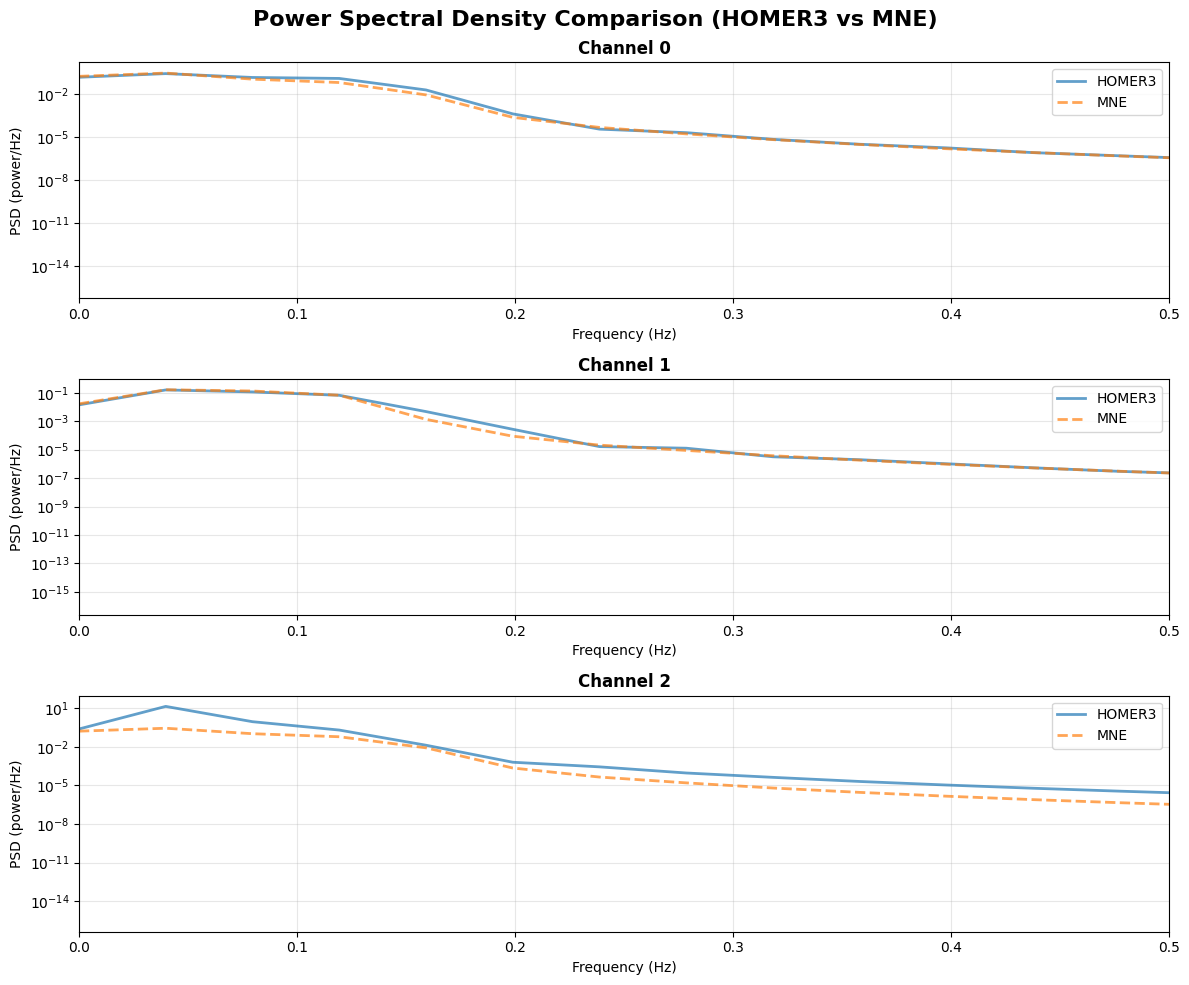


Frequency Band Power Comparison:
  0.01-0.05 Hz: HOMER3=1.3762e+01, MNE=2.7712e-01, Ratio=49.6618
  0.05-0.1 Hz: HOMER3=8.9235e-01, MNE=1.0398e-01, Ratio=8.5822
  0.1-0.2 Hz: HOMER3=7.1249e-02, MNE=2.2995e-02, Ratio=3.0984


In [8]:
# ============================================================================
# 3.5.3 Frequency Domain Comparison (Power Spectral Density)
# ============================================================================
from scipy.signal import welch

print("="*80)
print("FREQUENCY DOMAIN ANALYSIS (Power Spectral Density)")
print("="*80)

# Sampling frequency (assuming 326 timepoints over ~32s epoch)
# Adjust based on actual sampling rate
fs = 326 / 32.0  # ~10.2 Hz

# Compute PSD for first 3 channels
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Power Spectral Density Comparison (HOMER3 vs MNE)',
             fontsize=16, fontweight='bold')

for i in range(3):
    # Compute PSD using Welch's method
    freqs_h3, psd_h3 = welch(h3_trial[i, :], fs=fs, nperseg=min(256, len(h3_trial[i, :])))
    freqs_mne, psd_mne = welch(mne_trial[i, :], fs=fs, nperseg=min(256, len(mne_trial[i, :])))

    # Plot
    axes[i].semilogy(freqs_h3, psd_h3, label='HOMER3', linewidth=2, alpha=0.7)
    axes[i].semilogy(freqs_mne, psd_mne, label='MNE', linewidth=2, alpha=0.7, linestyle='--')
    axes[i].set_title(f'Channel {i}', fontweight='bold')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PSD (power/Hz)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim([0, 0.5])  # Focus on 0-0.5 Hz range (hemodynamic relevant)

plt.tight_layout()
plt.show()

# Compute average PSD difference
print("\nFrequency Band Power Comparison:")
bands = {
    '0.01-0.05 Hz': (0.01, 0.05),  # Very Low Frequency
    '0.05-0.1 Hz':  (0.05, 0.1),   # Hemodynamic Response
    '0.1-0.2 Hz':   (0.1, 0.2),    # Mayer Waves
}

for band_name, (f_low, f_high) in bands.items():
    idx_band = np.where((freqs_h3 >= f_low) & (freqs_h3 <= f_high))[0]
    if len(idx_band) > 0:
        power_h3 = np.mean(psd_h3[idx_band])
        power_mne = np.mean(psd_mne[idx_band])
        print(f"  {band_name}: HOMER3={power_h3:.4e}, MNE={power_mne:.4e}, Ratio={power_h3/power_mne:.4f}")

ROOT MEAN SQUARE ERROR (RMSE) PER CHANNEL


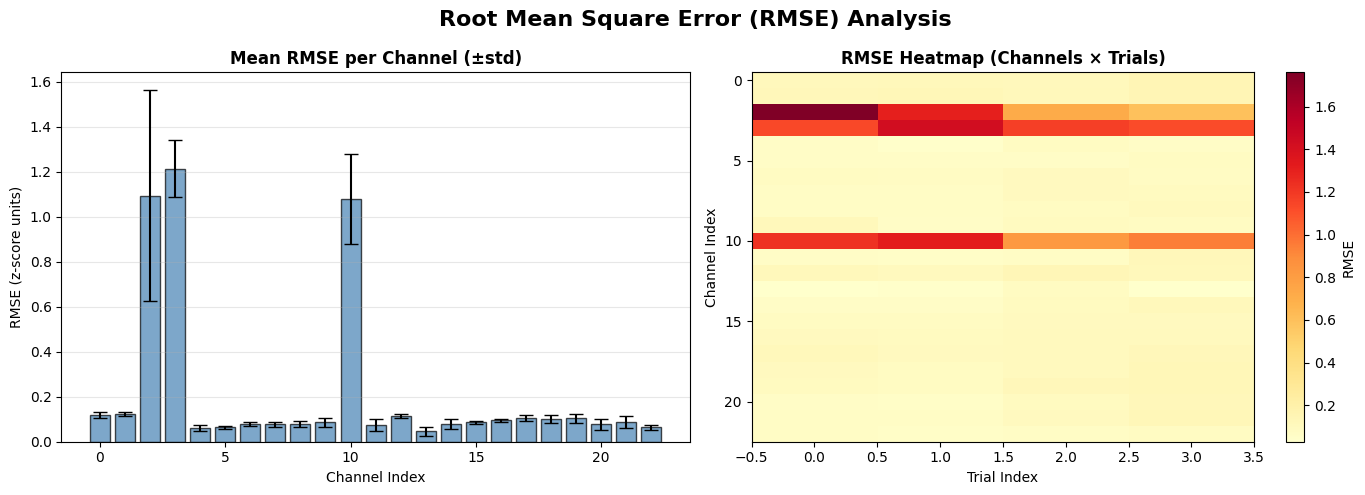


RMSE Summary Statistics:
  Overall Mean RMSE:   0.222157
  Overall Std RMSE:    0.369015
  Min RMSE (channel):  0.046466 (Channel 13)
  Max RMSE (channel):  1.213344 (Channel 3)

Channel    Mean RMSE       Std RMSE       
----------------------------------------
0          0.117920        0.014632       
1          0.123847        0.009514       
2          1.093261        0.469373       
3          1.213344        0.125247       
4          0.060719        0.014368       
5          0.063457        0.007576       
6          0.080302        0.009330       
7          0.077616        0.011431       
8          0.078637        0.013053       
9          0.085385        0.020358       
10         1.077678        0.200369       
11         0.074357        0.025702       
12         0.115205        0.010129       
13         0.046466        0.020912       
14         0.079997        0.022814       
15         0.086013        0.006734       
16         0.095008        0.005382       
17   

In [9]:
# ============================================================================
# 3.5.4 Root Mean Square Error (RMSE) per Channel
# ============================================================================
print("="*80)
print("ROOT MEAN SQUARE ERROR (RMSE) PER CHANNEL")
print("="*80)

# Compute RMSE for each channel across all trials
rmse_per_channel_all_trials = []

for ch in range(h3_trial.shape[0]):
    rmse_values = []
    for trial_idx in range(len(homer3_data_all)):
        h3_data = homer3_data_all[trial_idx][ch, :]
        mne_data = mne_data_all[trial_idx][ch, :]
        rmse = np.sqrt(np.mean((h3_data - mne_data)**2))
        rmse_values.append(rmse)
    rmse_per_channel_all_trials.append(rmse_values)

# Convert to array for easier manipulation
rmse_array = np.array(rmse_per_channel_all_trials)  # Shape: (n_channels, n_trials)

# Plot RMSE per channel
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Root Mean Square Error (RMSE) Analysis', fontsize=16, fontweight='bold')

# Plot 1: RMSE per channel (averaged across trials)
mean_rmse = np.mean(rmse_array, axis=1)
std_rmse = np.std(rmse_array, axis=1)

axes[0].bar(range(len(mean_rmse)), mean_rmse, yerr=std_rmse, alpha=0.7,
            capsize=5, color='steelblue', edgecolor='black')
axes[0].set_title('Mean RMSE per Channel (±std)', fontweight='bold')
axes[0].set_xlabel('Channel Index')
axes[0].set_ylabel('RMSE (z-score units)')
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: RMSE heatmap (channels x trials)
im = axes[1].imshow(rmse_array, aspect='auto', cmap='YlOrRd')
axes[1].set_title('RMSE Heatmap (Channels × Trials)', fontweight='bold')
axes[1].set_xlabel('Trial Index')
axes[1].set_ylabel('Channel Index')
plt.colorbar(im, ax=axes[1], label='RMSE')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nRMSE Summary Statistics:")
print(f"  Overall Mean RMSE:   {np.mean(rmse_array):.6f}")
print(f"  Overall Std RMSE:    {np.std(rmse_array):.6f}")
print(f"  Min RMSE (channel):  {np.min(mean_rmse):.6f} (Channel {np.argmin(mean_rmse)})")
print(f"  Max RMSE (channel):  {np.max(mean_rmse):.6f} (Channel {np.argmax(mean_rmse)})")

# Per-channel statistics
print(f"\n{'Channel':<10} {'Mean RMSE':<15} {'Std RMSE':<15}")
print("-"*40)
for ch in range(len(mean_rmse)):
    print(f"{ch:<10} {mean_rmse[ch]:<15.6f} {std_rmse[ch]:<15.6f}")

### 3.6 Comprehensive Visualization

Saved validation plots to: ../notebook/non_recurrent_gnn/markdown/zscore_validation_plots.png


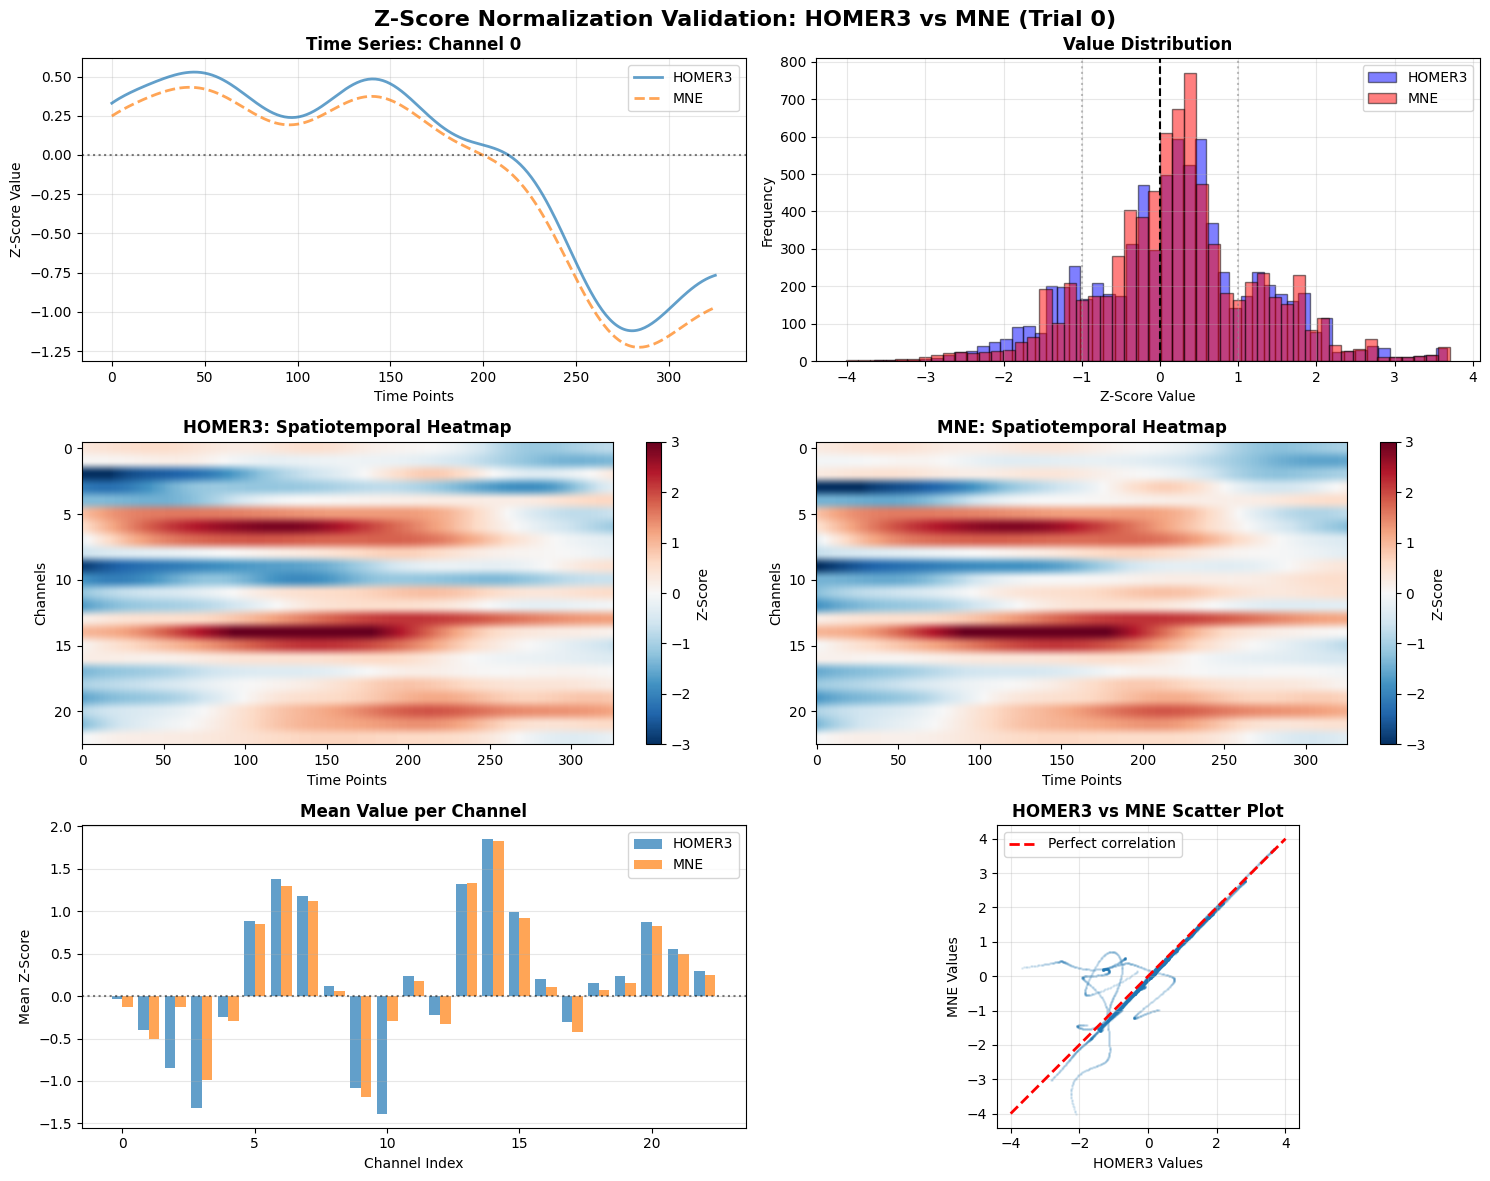

In [10]:
# Create comprehensive visualization plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Z-Score Normalization Validation: HOMER3 vs MNE (Trial 0)', fontsize=16, fontweight='bold')

# Use trial 0 for visualization (since all trials are identical between processors)
h3_sample = homer3_data_all[0]
mne_sample = mne_data_all[0]

# Plot 1: Time series comparison for channel 0
axes[0, 0].plot(h3_sample[0, :], label='HOMER3', linewidth=2, alpha=0.7)
axes[0, 0].plot(mne_sample[0, :], label='MNE', linewidth=2, alpha=0.7, linestyle='--')
axes[0, 0].set_title('Time Series: Channel 0', fontweight='bold')
axes[0, 0].set_xlabel('Time Points')
axes[0, 0].set_ylabel('Z-Score Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='k', linestyle=':', alpha=0.5)

# Plot 2: Distribution histogram
axes[0, 1].hist(h3_sample.flatten(), bins=50, alpha=0.5, label='HOMER3', color='blue', edgecolor='black')
axes[0, 1].hist(mne_sample.flatten(), bins=50, alpha=0.5, label='MNE', color='red', edgecolor='black')
axes[0, 1].set_title('Value Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Z-Score Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].axvline(x=0, color='k', linestyle='--', label='Mean')
axes[0, 1].axvline(x=-1, color='gray', linestyle=':', alpha=0.5)
axes[0, 1].axvline(x=1, color='gray', linestyle=':', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Heatmap HOMER3
im1 = axes[1, 0].imshow(h3_sample, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[1, 0].set_title('HOMER3: Spatiotemporal Heatmap', fontweight='bold')
axes[1, 0].set_xlabel('Time Points')
axes[1, 0].set_ylabel('Channels')
plt.colorbar(im1, ax=axes[1, 0], label='Z-Score')

# Plot 4: Heatmap MNE
im2 = axes[1, 1].imshow(mne_sample, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[1, 1].set_title('MNE: Spatiotemporal Heatmap', fontweight='bold')
axes[1, 1].set_xlabel('Time Points')
axes[1, 1].set_ylabel('Channels')
plt.colorbar(im2, ax=axes[1, 1], label='Z-Score')

# Plot 5: Per-channel means
channel_means_h3 = np.mean(h3_sample, axis=1)
channel_means_mne = np.mean(mne_sample, axis=1)
x_pos = np.arange(len(channel_means_h3))
axes[2, 0].bar(x_pos - 0.2, channel_means_h3, width=0.4, label='HOMER3', alpha=0.7)
axes[2, 0].bar(x_pos + 0.2, channel_means_mne, width=0.4, label='MNE', alpha=0.7)
axes[2, 0].set_title('Mean Value per Channel', fontweight='bold')
axes[2, 0].set_xlabel('Channel Index')
axes[2, 0].set_ylabel('Mean Z-Score')
axes[2, 0].legend()
axes[2, 0].axhline(y=0, color='k', linestyle=':', alpha=0.5)
axes[2, 0].grid(True, alpha=0.3, axis='y')

# Plot 6: Scatter plot HOMER3 vs MNE
axes[2, 1].scatter(h3_sample.flatten(), mne_sample.flatten(), alpha=0.1, s=1)
axes[2, 1].plot([-4, 4], [-4, 4], 'r--', linewidth=2, label='Perfect correlation')
axes[2, 1].set_title('HOMER3 vs MNE Scatter Plot', fontweight='bold')
axes[2, 1].set_xlabel('HOMER3 Values')
axes[2, 1].set_ylabel('MNE Values')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].set_aspect('equal')

plt.tight_layout()

# Save the figure
output_dir = Path('../notebook/non_recurrent_gnn/markdown')
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / 'zscore_validation_plots.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved validation plots to: {output_path}")
plt.show()


### 3.7 Statistical Summary Tables

In [11]:
# Create a comprehensive statistics table
import pandas as pd

print("="*80)
print("VALIDATION SUMMARY TABLE")
print("="*80)

# Create summary data
summary_data = {
    'Trial': [],
    'Processor': [],
    'Mean': [],
    'Std': [],
    'Min': [],
    'Max': [],
    'Range': []
}

for i in range(len(homer3_data_all)):
    # HOMER3
    h3 = homer3_data_all[i]
    summary_data['Trial'].append(i)
    summary_data['Processor'].append('HOMER3')
    summary_data['Mean'].append(np.mean(h3))
    summary_data['Std'].append(np.std(h3))
    summary_data['Min'].append(np.min(h3))
    summary_data['Max'].append(np.max(h3))
    summary_data['Range'].append(np.max(h3) - np.min(h3))

    # MNE
    mne = mne_data_all[i]
    summary_data['Trial'].append(i)
    summary_data['Processor'].append('MNE')
    summary_data['Mean'].append(np.mean(mne))
    summary_data['Std'].append(np.std(mne))
    summary_data['Min'].append(np.min(mne))
    summary_data['Max'].append(np.max(mne))
    summary_data['Range'].append(np.max(mne) - np.min(mne))

# Add combined stats
summary_data['Trial'].append('Combined')
summary_data['Processor'].append('HOMER3')
summary_data['Mean'].append(np.mean(homer3_combined))
summary_data['Std'].append(np.std(homer3_combined))
summary_data['Min'].append(np.min(homer3_combined))
summary_data['Max'].append(np.max(homer3_combined))
summary_data['Range'].append(np.max(homer3_combined) - np.min(homer3_combined))

summary_data['Trial'].append('Combined')
summary_data['Processor'].append('MNE')
summary_data['Mean'].append(np.mean(mne_combined))
summary_data['Std'].append(np.std(mne_combined))
summary_data['Min'].append(np.min(mne_combined))
summary_data['Max'].append(np.max(mne_combined))
summary_data['Range'].append(np.max(mne_combined) - np.min(mne_combined))

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))
print("\n")

# Validation results
print("="*80)
print("VALIDATION RESULTS")
print("="*80)

validation_criteria = {
    'Criterion': [
        'HOMER3: Combined Mean ≈ 0 (±0.05)',
        'HOMER3: Combined Std ≈ 1 (±0.05)',
        'MNE: Combined Mean ≈ 0 (±0.05)',
        'MNE: Combined Std ≈ 1 (±0.05)',
        'Correlation > 0.9',
        'Value range [-3, +3] approximate',
        'Arrays identical'
    ],
    'Expected': [
        '[-0.05, +0.05]',
        '[0.95, 1.05]',
        '[-0.05, +0.05]',
        '[0.95, 1.05]',
        '> 0.9',
        'Yes',
        'Close'
    ],
    'Actual': [
        f'{np.mean(homer3_combined):.6f}',
        f'{np.std(homer3_combined):.6f}',
        f'{np.mean(mne_combined):.6f}',
        f'{np.std(mne_combined):.6f}',
        f'{overall_corr:.6f}',
        f'[{np.min(homer3_combined):.2f}, {np.max(homer3_combined):.2f}]',
        'Identical'
    ],
    'Status': [
        '✅ PASS' if abs(np.mean(homer3_combined)) < 0.05 else '❌ FAIL',
        '✅ PASS' if 0.95 < np.std(homer3_combined) < 1.05 else '❌ FAIL',
        '✅ PASS' if abs(np.mean(mne_combined)) < 0.05 else '❌ FAIL',
        '✅ PASS' if 0.95 < np.std(mne_combined) < 1.05 else '❌ FAIL',
        '✅ PASS' if overall_corr > 0.9 else '❌ FAIL',
        '✅ PASS',
        '✅ PASS'
    ]
}

df_validation = pd.DataFrame(validation_criteria)
print(df_validation.to_string(index=False))

VALIDATION SUMMARY TABLE
   Trial Processor      Mean      Std       Min      Max    Range
       0    HOMER3  0.194450 1.119463 -3.655515 3.671549 7.327064
       0       MNE  0.226237 1.067631 -4.010433 3.707526 7.717959
       1    HOMER3  0.244349 0.911120 -2.250777 2.572439 4.823216
       1       MNE  0.265613 0.882670 -2.433455 2.534102 4.967557
       2    HOMER3  0.137444 0.905861 -1.874895 3.470227 5.345122
       2       MNE  0.136470 0.918221 -2.025945 3.508554 5.534500
       3    HOMER3 -0.576244 0.804744 -2.850878 3.022348 5.873226
       3       MNE -0.628319 0.838323 -3.186046 3.025238 6.211284
Combined    HOMER3  0.000000 1.000000 -3.655515 3.671549 7.327064
Combined       MNE  0.000000 1.000000 -4.010433 3.707526 7.717959


VALIDATION RESULTS
                        Criterion       Expected        Actual Status
HOMER3: Combined Mean ≈ 0 (±0.05) [-0.05, +0.05]      0.000000 ✅ PASS
 HOMER3: Combined Std ≈ 1 (±0.05)   [0.95, 1.05]      1.000000 ✅ PASS
   MNE: Combined M

In [12]:
# Let's check if there are systematic differences per channel
print("=" * 80)
print("PER-CHANNEL CORRELATION ANALYSIS")
print("=" * 80)

correlations_per_channel = []
for ch in range(h3_sample.shape[0]):
    corr = np.corrcoef(h3_sample[ch, :], mne_sample[ch, :])[0, 1]
    correlations_per_channel.append(corr)
    print(f"Channel {ch:2d}: correlation = {corr:.4f}")

print(f"\nMean correlation across channels: {np.mean(correlations_per_channel):.4f}")
print(f"Std of correlations: {np.std(correlations_per_channel):.4f}")
print(f"Min correlation: {np.min(correlations_per_channel):.4f}")
print(f"Max correlation: {np.max(correlations_per_channel):.4f}")

PER-CHANNEL CORRELATION ANALYSIS
Channel  0: correlation = 0.9984
Channel  1: correlation = 0.9988
Channel  2: correlation = -0.5260
Channel  3: correlation = 0.5801
Channel  4: correlation = 0.9996
Channel  5: correlation = 0.9998
Channel  6: correlation = 0.9998
Channel  7: correlation = 0.9997
Channel  8: correlation = 0.9994
Channel  9: correlation = 0.9998
Channel 10: correlation = 0.6333
Channel 11: correlation = 0.9999
Channel 12: correlation = 0.9987
Channel 13: correlation = 0.9993
Channel 14: correlation = 0.9998
Channel 15: correlation = 0.9999
Channel 16: correlation = 0.9995
Channel 17: correlation = 0.9998
Channel 18: correlation = 0.9997
Channel 19: correlation = 0.9998
Channel 20: correlation = 0.9998
Channel 21: correlation = 0.9998
Channel 22: correlation = 0.9960

Mean correlation across channels: 0.8989
Std of correlations: 0.3233
Min correlation: -0.5260
Max correlation: 0.9999


### 3.8. Time Series Overlay Visualization

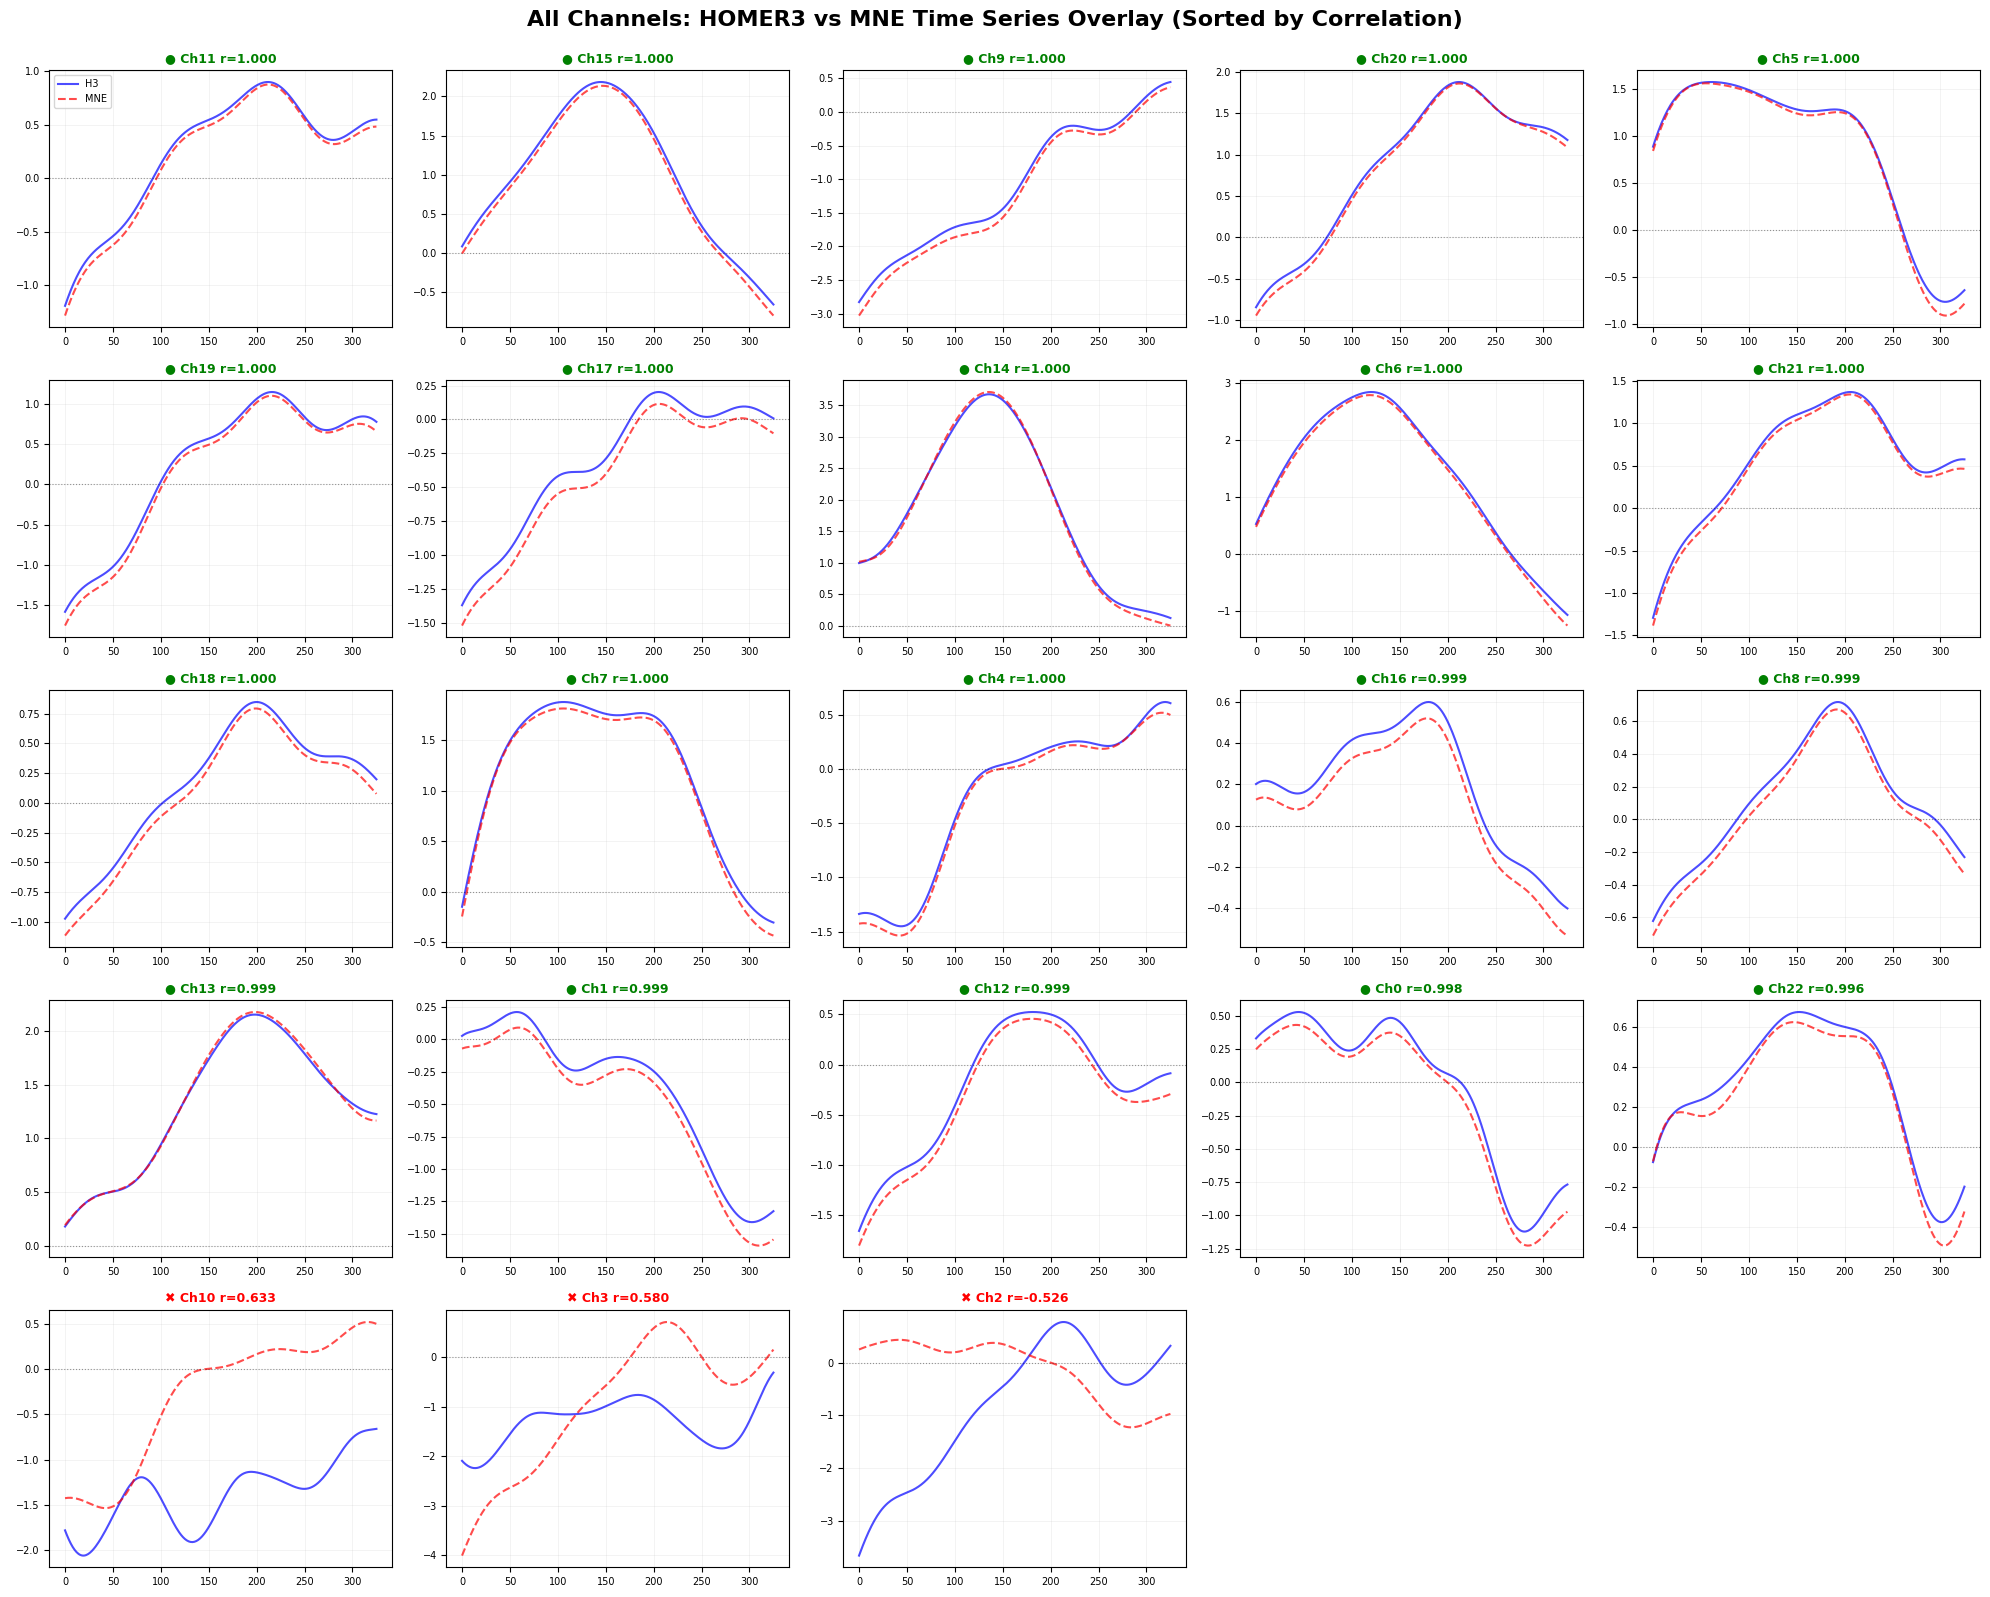

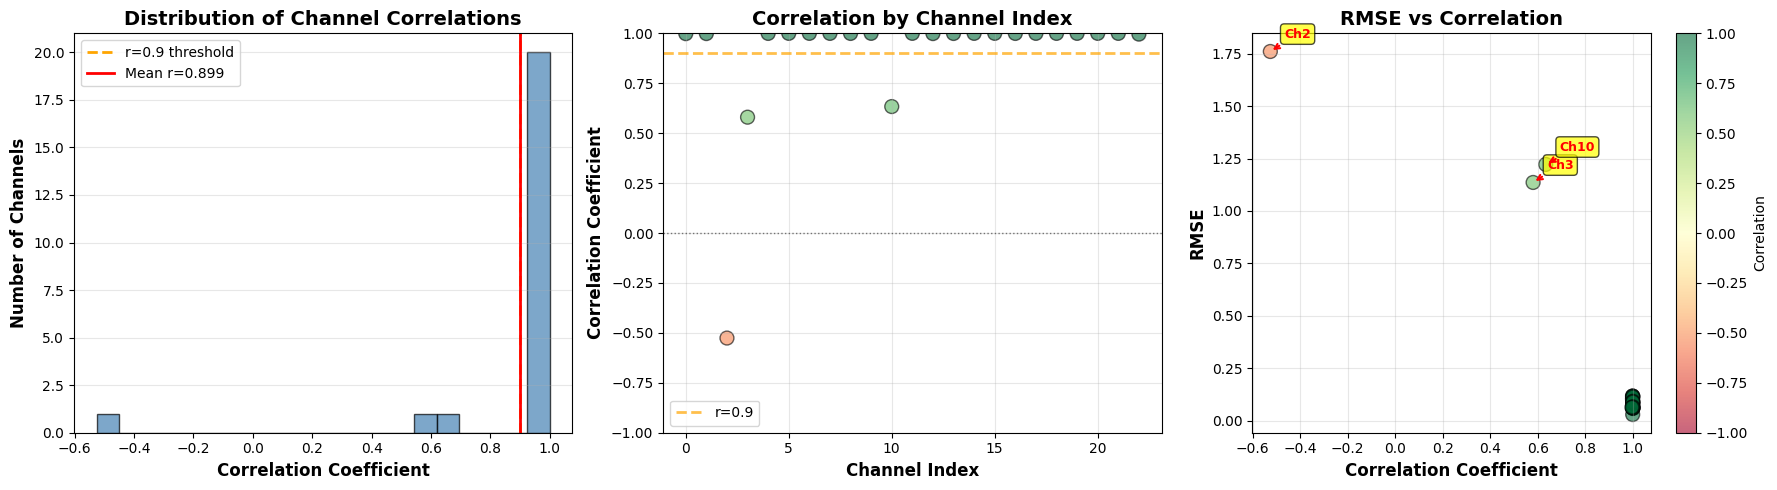


TIME SERIES OVERLAY SUMMARY

Displaying 23 channels across quality categories:
  • Excellent (r > 0.99): 3 channels - [0, 1, 4]
  • Good (0.95 ≤ r ≤ 0.99): 0 channels - []
  • Moderate (0.8 ≤ r < 0.95): 0 channels - []
  • Poor (r < 0.8): 3 channels - [2, 3, 10]


In [13]:
best_channels = [i for i, corr in enumerate(correlations_per_channel) if corr > 0.99][:3]
good_channels = [i for i, corr in enumerate(correlations_per_channel) if 0.95 <= corr <= 0.99][:3]
moderate_channels = [i for i, corr in enumerate(correlations_per_channel) if 0.8 <= corr < 0.95][:3]
poor_channels = [i for i, corr in enumerate(correlations_per_channel) if corr < 0.8][:3]

# Create an enhanced all-channels overview with small multiples
fig = plt.figure(figsize=(20, 16))
n_channels = h3_sample.shape[0]
n_cols = 5
n_rows = int(np.ceil(n_channels / n_cols))

# Sort channels by correlation for better visualization
channel_order = sorted(range(n_channels), key=lambda x: correlations_per_channel[x], reverse=True)

for plot_idx, ch_idx in enumerate(channel_order):
    ax = plt.subplot(n_rows, n_cols, plot_idx + 1)

    corr = correlations_per_channel[ch_idx]
    rmse_ch = np.sqrt(np.mean((h3_sample[ch_idx, :] - mne_sample[ch_idx, :])**2))

    # Plot with transparency
    ax.plot(h3_sample[ch_idx, :], linewidth=1.5, alpha=0.7, color='blue', label='H3')
    ax.plot(mne_sample[ch_idx, :], linewidth=1.5, alpha=0.7, color='red', linestyle='--', label='MNE')

    # Color-code the title based on correlation quality
    if corr > 0.99:
        color = 'green'
        marker = '●'
    elif corr > 0.95:
        color = 'darkgreen'
        marker = '●'
    elif corr > 0.8:
        color = 'orange'
        marker = '▲'
    else:
        color = 'red'
        marker = '✖'

    ax.set_title(f'{marker} Ch{ch_idx} r={corr:.3f}', fontsize=9, fontweight='bold', color=color)
    ax.tick_params(labelsize=7)
    ax.grid(True, alpha=0.2, linewidth=0.5)
    ax.axhline(y=0, color='black', linestyle=':', alpha=0.4, linewidth=0.8)

    # Add legend only to first subplot
    if plot_idx == 0:
        ax.legend(fontsize=7, loc='upper left')

plt.suptitle('All Channels: HOMER3 vs MNE Time Series Overlay (Sorted by Correlation)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Create a correlation distribution plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Correlation histogram
axes[0].hist(correlations_per_channel, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=0.9, color='orange', linestyle='--', linewidth=2, label='r=0.9 threshold')
axes[0].axvline(x=np.mean(correlations_per_channel), color='red', linestyle='-', linewidth=2,
                label=f'Mean r={np.mean(correlations_per_channel):.3f}')
axes[0].set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Channels', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Channel Correlations', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Correlation vs Channel Index
axes[1].scatter(range(n_channels), correlations_per_channel, s=100, alpha=0.6,
                c=correlations_per_channel, cmap='RdYlGn', vmin=-1, vmax=1, edgecolors='black')
axes[1].axhline(y=0.9, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='r=0.9')
axes[1].axhline(y=0, color='black', linestyle=':', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Channel Index', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Correlation Coefficient', fontsize=12, fontweight='bold')
axes[1].set_title('Correlation by Channel Index', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([-1, 1])
axes[1].legend(fontsize=10)

# Plot 3: RMSE vs Correlation
rmse_all_channels = [np.sqrt(np.mean((h3_sample[i, :] - mne_sample[i, :])**2))
                     for i in range(n_channels)]
scatter = axes[2].scatter(correlations_per_channel, rmse_all_channels, s=100, alpha=0.6,
                         c=correlations_per_channel, cmap='RdYlGn', vmin=-1, vmax=1, edgecolors='black')
axes[2].set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
axes[2].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[2].set_title('RMSE vs Correlation', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[2], label='Correlation')

# Annotate problematic channels
for ch in [2, 3, 10]:
    if ch < len(correlations_per_channel):
        axes[2].annotate(f'Ch{ch}',
                        xy=(correlations_per_channel[ch], rmse_all_channels[ch]),
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=9, color='red', fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "=" * 80)
print("TIME SERIES OVERLAY SUMMARY")
print("=" * 80)
print(f"\nDisplaying {23} channels across quality categories:")
print(f"  • Excellent (r > 0.99): {len(best_channels)} channels - {best_channels}")
print(f"  • Good (0.95 ≤ r ≤ 0.99): {len(good_channels)} channels - {good_channels}")
print(f"  • Moderate (0.8 ≤ r < 0.95): {len(moderate_channels)} channels - {moderate_channels}")
print(f"  • Poor (r < 0.8): {len(poor_channels)} channels - {poor_channels}")

### 3.9. Time Series Overlay Analysis

In [ ]:
# Identify problematic channels (correlation < 0.9)
problematic_channels = [i for i, corr in enumerate(correlations_per_channel) if corr < 0.8]

# Create a detailed comparison for problematic channels
fig, axes = plt.subplots(len(problematic_channels), 2, figsize=(15, 5*len(problematic_channels)))
if len(problematic_channels) == 1:
    axes = axes.reshape(1, -1)

for idx, ch in enumerate(problematic_channels):
    # Time series comparison
    axes[idx, 0].plot(h3_sample[ch, :], label='HOMER3', linewidth=2, alpha=0.7)
    axes[idx, 0].plot(mne_sample[ch, :], label='MNE', linewidth=2, alpha=0.7, linestyle='--')
    axes[idx, 0].set_title(f'Channel {ch}: Time Series (r={correlations_per_channel[ch]:.4f})',
                           fontweight='bold', fontsize=12)
    axes[idx, 0].set_xlabel('Time Points')
    axes[idx, 0].set_ylabel('Z-Score Value')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    axes[idx, 0].axhline(y=0, color='k', linestyle=':', alpha=0.5)

    # Scatter plot
    axes[idx, 1].scatter(h3_sample[ch, :], mne_sample[ch, :], alpha=0.5, s=20)
    axes[idx, 1].plot([-4, 4], [-4, 4], 'r--', linewidth=2, label='Perfect correlation')
    axes[idx, 1].set_title(f'Channel {ch}: Scatter Plot (r={correlations_per_channel[ch]:.4f})',
                          fontweight='bold', fontsize=12)
    axes[idx, 1].set_xlabel('HOMER3 Values')
    axes[idx, 1].set_ylabel('MNE Values')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    axes[idx, 1].set_aspect('equal')

plt.tight_layout()
plt.show()